# Graph generation

In this notebook, we do the following three things:

1. We extract all links between the HCPs. To do this, we use the PubMed and Google Scholar data, respectively, to determine the "links by joint paper" and "links by joint journal". Based on this data, we first determine the 1-hop neighbors, the 2-hop neighbors and the combination thereof, the 1-2-hop neighbors of a HCP, considering one of the two link types. We then work only with the 1-hop neighbors of a HCP and extract the links. We do this for links by joint paper and links by joint journal using PubMed as well as for links by joint paper and links by joint journal using Google Scholar. We then extract links by joint hospital using our targets data. From the set of all links, we can generate the HCP graph.

2. For each HCP, we collect the node features to use them in later tasks and also put them in the form needed later.

3. For each link, we collect its features, which are not used in later tasks, but still useful to capture which link types are behind a link in the HCP graph. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import pickle
import os

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import json

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def reverse(tuples):
    """
    Reverse a 2-tuple.
    """
    new_tup = tuples[::-1]
    
    return new_tup

In [3]:
def n_neighbor(G, id, n_hop):
    node = [id]
    node_visited = set()
    neighbors= []
    
    while n_hop != 0:
        neighbors= []
        for node_id in node:
            node_visited.add(node_id)
            neighbors +=  [id for id in G.neighbors(node_id) if id not in node_visited]
        node = neighbors
        n_hop -= 1
        
        if len(node) == 0:
            return neighbors 
        
    return list(set(neighbors))

In [4]:
# For our application, the doctor/nurse names must only contain the first first name and last last name.
def truncate_names_1(data, column):
    """
    Truncate names.
    """
    for i in range(len(data)):
        names_list = data[column][i].split(", ")
        names_list_truncated = []
        for j in range(len(names_list)):
            names_list_split = names_list[j].lstrip().rstrip().replace("-", " ").split(" ")
            name = names_list_split[0] + ' ' + names_list_split[-1]
            #name = names_list_split[0][0] + ' ' + names_list_split[-1]
            names_list_truncated += [name]
            
        names_truncated = ", ".join(names_list_truncated) 
            
        data.at[i, column] = names_truncated
        
    return data

In [5]:
# For our application, the doctor/nurse names must only contain the first first name and last last name.
# This function was tailored to the calls data, only truncating names of HCPs, not those of HCO!!!
def truncate_names_in_calls(data, column, hcp_indicator):
    """
    Truncate names.
    """
    for i in range(len(data)):
        if data[hcp_indicator][i] == 'HCP':
            names_list = data[column][i].split(", ")
            names_list_truncated = []
            for j in range(len(names_list)):
                names_list_split = names_list[j].lstrip().rstrip().replace("-", " ").split(" ")
                name = names_list_split[0] + ' ' + names_list_split[-1]
                #name = names_list_split[0][0] + ' ' + names_list_split[-1]
                names_list_truncated += [name]
            
            names_truncated = ", ".join(names_list_truncated) 
            
            data.at[i, column] = names_truncated
        
    return data

In [6]:
def normalize(data, variable):
    """
    Normalization of variable in data frame.
    """
    data[f"{variable}_norm"] = (data[variable] - data[variable].min()) / (data[variable].max() - data[variable].min())
    data.drop(variable, axis=1, inplace=True)

    return data

In [7]:
def dummy_encode(data, variable):
    """
    Get dummies of variable in data frame.
    """
    encoder_df = pd.get_dummies(data[variable])
    data = data.join(encoder_df)
    data.drop(variable, axis=1, inplace=True)

    return data

## Load data 

In [8]:
# load the scraped data
hcp_df_pubmed = pd.read_csv("../1_data_processing/processed_data/results_pm.csv")
hcp_df_gs = pd.read_csv("../1_data_processing/processed_data/results_gs.csv")
targets = pd.read_pickle("../1_data_processing/processed_data/targets.pkl")

hospital_counts = pd.read_pickle("../1_data_processing/processed_data/hospital_counts.pkl")
hcp_counts = pd.read_pickle("../1_data_processing/processed_data/hcp_counts.pkl")

population = pd.read_pickle("../1_data_processing/processed_data/population_by_region.pkl")

calls = pd.read_pickle("../1_data_processing/processed_data/calls.pkl")
patients = pd.read_pickle("../1_data_processing/processed_data/patients.pkl")
sales = pd.read_pickle("../1_data_processing/processed_data/sales.pkl")

print(hcp_df_pubmed.shape)
print(hcp_df_gs.shape)
print(targets.shape)

(2664, 9)
(1449, 9)
(229, 14)


## 1. Extraction of links

### PubMed data

In [9]:
hcp_df_pubmed

,hcp_name,num_articles,abstract,authors,journal,keywords,publication_year,title,scraped_from
0,Aglaia Schiza,6,the immune microenvironment important modulato...,"Aglaia Schiza, Viktoria Thurfjell, Axel Tullbe...","european journal of cancer (oxford, england : ...","ductal carcinoma in situ, radiotherapy, ttumou...",2022,tumourinfiltrating lymphocytes add prognostic ...,pm
1,Aglaia Schiza,6,trastuzumab emtansine (t-dm1) presently approv...,"Thomas Hatschek, Theodoros Foukakis, Judith Bj...",jama oncology,NaN,2021,neoadjuvant trastuzumab pertuzumab docetaxel v...,pm
2,Aglaia Schiza,6,this study analyzes potential stromal platelet...,"Carina Strell, Dick Folkvaljon, Erik Holmberg,...",clinical cancer research : an official journal...,NaN,2021,high pdgfrb expression predicts resistance rad...,pm
3,Aglaia Schiza,6,there conflicting results potential role her2-...,"Aglaia Schiza, Davide Mauri, Irma Fredriksson,...",breast cancer research and treatment,"adjuvant, breast cancer, endocrine treatment, ...",2020,predictive role her2status effectiveness endoc...,pm
4,Aglaia Schiza,6,the purpose evaluate potential diffusion-weigh...,"Aglaia Schiza, Sandra Irenaeus, Francisco Niet...",scientific reports,NaN,2019,evaluation diffusionweighted mri fdgpetct asse...,pm
...,...,...,...,...,...,...,...,...,...
2659,Anna Nyberg,33,to provide practicing nurse anaesthetists evid...,"Roland Nilsson, Chatarina Björdal, Matts Ander...",journal of clinical nursing,NaN,2005,health risks occupational exposure volatile an...,pm
2660,Mikael Wallander,1,while recent randomised phase iii trials trifl...,"Mikael Wallander, Bo Rolander, Elisabeth Lundq...",journal of gastrointestinal oncology,"trifluridine and tiperacil (tas-102), chemothe...",2020,real world aspects palliative trifluridine plu...,pm
2661,Frida Jakobsson,3,treating localized prostate cancer (pc) combin...,"Johan Olsén, Dalia Estefan, Antonios Valachis,...",journal of contemporary brachytherapy,"hdr, boost, brachytherapy, hypo-fractionation,...",2022,predicting toxicity caused highdoserate brachy...,pm
2662,Frida Jakobsson,3,the benefit imaging follow-up setting high-ris...,"Ylva Naeser, Hildur Helgadottir, Johan Hansson...",cancers,"x-ray computed, follow-up studies, melanoma, p...",2022,quality life first year followup randomized mu...,pm


### Links by joint paper

In [10]:
link_list = []

for doctor in hcp_df_pubmed['hcp_name'].unique():
    doc_dict = dict()
    
    hcp_df_pubmed_filtered = hcp_df_pubmed[hcp_df_pubmed['hcp_name'] == doctor].reset_index(drop = True)
    
    published_with = []
    for i in range(len(hcp_df_pubmed_filtered)): 
        author_list = hcp_df_pubmed_filtered['authors'][i].split(", ")
        published_with += author_list
        
    published_with = list(set(published_with))
    published_with.remove(doctor) 
    
    doc_dict = {'doctor': doctor,
                'published_with': published_with}
    
    link_list += [doc_dict]

# create all edges
edge_list = []
for doc_dict in link_list:
    for i in range(len(doc_dict['published_with'])):
        edge_list += [[f"{doc_dict['doctor']}", f"{doc_dict['published_with'][i]}"]]
            
# make sure every edge only exists once
edge_list_updated = []
for edge in edge_list:
    if edge not in edge_list_updated:
        if reverse(edge) not in edge_list_updated:
            edge_list_updated += [edge]
            
edge_list_updated
    
## construct graph
DN_pm_papers = nx.Graph()
DN_pm_papers.add_edges_from(edge_list_updated)

In [11]:
print(DN_pm_papers.number_of_nodes())
print(DN_pm_papers.number_of_edges())

11204
17515


With this initial graph, we can now start to look at the 1-hop and 2-hop neighbors of each node in the graph.
Be aware: Only links can be created between HCPs for whom papers could be scraped on PubMed. But for these HCPs for whom papers could be scraped we can do the following two things:

- create more links for HCPs who are already linked in DN_pm_papers
- create links for HCPs who are not yet linked in DN_pm_papers

Therefore, both the number of nodes and the number of edges can be increased.

In [12]:
# create data frame with 1-hop, 2-hop and 1-2-hop neighbors
neighbors_pm_papers_1h_2h = pd.DataFrame(columns=['hcp_name', 'one_hop_neighbors', 'two_hop_neighbors', 'one_two_hop_neighbors'])
    
doctors = hcp_df_pubmed['hcp_name'].unique().tolist()

for doctor in doctors:
    neighbors_pm_papers_1h_2h = neighbors_pm_papers_1h_2h.append({'hcp_name': doctor, 
                                                            'one_hop_neighbors': n_neighbor(DN_pm_papers, doctor, 1),
                                                            'two_hop_neighbors': n_neighbor(DN_pm_papers, doctor, 2),
                                                            'one_two_hop_neighbors': n_neighbor(DN_pm_papers, doctor, 1) + n_neighbor(DN_pm_papers, doctor, 2)}, ignore_index=True)

neighbors_pm_papers_1h_2h

,hcp_name,one_hop_neighbors,two_hop_neighbors,one_two_hop_neighbors
0,Aglaia Schiza,"[Jonas Bergh, Amanda Lindberg, Carina Strell, ...","[Lisa Ryden, Nils Bengtsson, Katarzyna Jóźwiak...","[Jonas Bergh, Amanda Lindberg, Carina Strell, ..."
1,Agneta Danfors,"[Dimitrios Papantoniou, Antonios Valachis, Fri...","[Simon Ekman, Peter Vuylsteke, John Lövrot, Jo...","[Dimitrios Papantoniou, Antonios Valachis, Fri..."
2,Alaa Haidar,"[Kagan Tuncay, Lisa Ensman, Jingjun Sun, Peter...",[],"[Kagan Tuncay, Lisa Ensman, Jingjun Sun, Peter..."
3,Ana Campos,"[Sadhna Vora, Jessica Tao, Åke Borg, Vanessa O...","[Lambert Skoog, Shaobo Jin, John Lövrot, Paris...","[Sadhna Vora, Jessica Tao, Åke Borg, Vanessa O..."
4,Andreas Nearchou,"[Marie Tabone, Antonio Petrilli, Antonis Valac...","[Simon Ekman, Léonor Benhaim, Peter Vuylsteke,...","[Marie Tabone, Antonio Petrilli, Antonis Valac..."
...,...,...,...,...
129,Theodoros Foukakis,"[Lambert Skoog, Ulf Pettersson, John Lövrot, N...","[Léonor Benhaim, Klaus Scholich, Gunnar Åström...","[Lambert Skoog, Ulf Pettersson, John Lövrot, N..."
130,Ylva Stenlund,"[Milos Kesek, Steen Jensen]",[],"[Milos Kesek, Steen Jensen]"
131,Anna Nyberg,"[Ida Madsen, Linda Hanson, Kristina Johnell, M...",[Karin Nilsson],"[Ida Madsen, Linda Hanson, Kristina Johnell, M..."
132,Mikael Wallander,"[Elisabeth Lundqvist, Bo Rolander, Nils Elander]","[Kristina Engvall, Dimitrios Papantoniou, Chri...","[Elisabeth Lundqvist, Bo Rolander, Nils Elande..."


We now want to create links - of course only between doctors in `hcp_name`. 

#### 1-hop neighbors

In [13]:
# create link list for 1-hop neighbors
links_pm_paper_1h = []
for i in range(len(neighbors_pm_papers_1h_2h)):
    doctor = neighbors_pm_papers_1h_2h['hcp_name'][i]
    for neighbor in neighbors_pm_papers_1h_2h['one_hop_neighbors'][i]:
        if neighbor in neighbors_pm_papers_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_pm_paper_1h:
                if reverse(link) not in links_pm_paper_1h:
                    links_pm_paper_1h += [link]
print(len(links_pm_paper_1h))

441


In [14]:
links_pm_paper_1h

[['Aglaia Schiza', 'Jonas Bergh'],
 ['Aglaia Schiza', 'Ann Dreifaldt'],
 ['Aglaia Schiza', 'Judith Bjöhle'],
 ['Aglaia Schiza', 'Tobias Lekberg'],
 ['Aglaia Schiza', 'Theodoros Foukakis'],
 ['Aglaia Schiza', 'Thomas Hatschek'],
 ['Aglaia Schiza', 'Per Karlsson'],
 ['Aglaia Schiza', 'Johan Hartman'],
 ['Aglaia Schiza', 'Zakaria Einbeigi'],
 ['Aglaia Schiza', 'Gustav Ullenhag'],
 ['Aglaia Schiza', 'Irma Fredriksson'],
 ['Aglaia Schiza', 'Jamila Adra'],
 ['Aglaia Schiza', 'Antonios Valachis'],
 ['Aglaia Schiza', 'Henrik Lindman'],
 ['Aglaia Schiza', 'Erika Friman'],
 ['Agneta Danfors', 'Dimitrios Papantoniou'],
 ['Agneta Danfors', 'Antonios Valachis'],
 ['Agneta Danfors', 'Frida Jakobsson'],
 ['Agneta Danfors', 'Hildur Helgadottir'],
 ['Agneta Danfors', 'Ylva Naeser'],
 ['Agneta Danfors', 'Petra Flygare'],
 ['Agneta Danfors', 'Cecilia Nilsson'],
 ['Agneta Danfors', 'Gustav Ullenhag'],
 ['Ana Campos', 'Johan Hartman'],
 ['Andreas Nearchou', 'Anna Wennstig'],
 ['Andreas Nearchou', 'Anthoula

In [15]:
## construct graph
DN_pm_paper_1h = nx.Graph()
DN_pm_paper_1h.add_edges_from(links_pm_paper_1h)

In [16]:
print(DN_pm_paper_1h.number_of_nodes())
print(DN_pm_paper_1h.number_of_edges())

94
441


#### 1-2-hop neighbors

In [17]:
# create link list for 1-2-hop neighbors
links_pm_paper_1h2h = []
for i in range(len(neighbors_pm_papers_1h_2h)):
    doctor = neighbors_pm_papers_1h_2h['hcp_name'][i]
    for neighbor in neighbors_pm_papers_1h_2h['one_two_hop_neighbors'][i]:
        if neighbor in neighbors_pm_papers_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_pm_paper_1h2h:
                if reverse(link) not in links_pm_paper_1h2h:
                    links_pm_paper_1h2h += [link]
print(len(links_pm_paper_1h2h))

2999


In [18]:
links_pm_paper_1h2h

[['Aglaia Schiza', 'Jonas Bergh'],
 ['Aglaia Schiza', 'Ann Dreifaldt'],
 ['Aglaia Schiza', 'Judith Bjöhle'],
 ['Aglaia Schiza', 'Tobias Lekberg'],
 ['Aglaia Schiza', 'Theodoros Foukakis'],
 ['Aglaia Schiza', 'Thomas Hatschek'],
 ['Aglaia Schiza', 'Per Karlsson'],
 ['Aglaia Schiza', 'Johan Hartman'],
 ['Aglaia Schiza', 'Zakaria Einbeigi'],
 ['Aglaia Schiza', 'Gustav Ullenhag'],
 ['Aglaia Schiza', 'Irma Fredriksson'],
 ['Aglaia Schiza', 'Jamila Adra'],
 ['Aglaia Schiza', 'Antonios Valachis'],
 ['Aglaia Schiza', 'Henrik Lindman'],
 ['Aglaia Schiza', 'Erika Friman'],
 ['Aglaia Schiza', 'Nils Bengtsson'],
 ['Aglaia Schiza', 'Yvonne Wengström'],
 ['Aglaia Schiza', 'Johan Falkenius'],
 ['Aglaia Schiza', 'Samuel Rotstein'],
 ['Aglaia Schiza', 'Johan Ahlgren'],
 ['Aglaia Schiza', 'Liselott Sahlberg'],
 ['Aglaia Schiza', 'Anna Väppling'],
 ['Aglaia Schiza', 'Agneta Danfors'],
 ['Aglaia Schiza', 'Hildur Helgadottir'],
 ['Aglaia Schiza', 'Petra Flygare'],
 ['Aglaia Schiza', 'Martin Malmberg'],
 ['

In [19]:
## construct graph
DN_pm_paper_1h2h = nx.Graph()
DN_pm_paper_1h2h.add_edges_from(links_pm_paper_1h2h)
##nx.draw(DN, with_labels=with_labels)

In [20]:
print(DN_pm_paper_1h2h.number_of_nodes())
print(DN_pm_paper_1h2h.number_of_edges())

123
2999


### Links by joint journal

In [21]:
journal_list = []

for doctor in hcp_df_pubmed['hcp_name'].unique():
    doc_dict = dict()
    
    hcp_df_pubmed_filtered = hcp_df_pubmed[hcp_df_pubmed['hcp_name'] == doctor].reset_index(drop = True)
    
    journals = []
    
    for i in range(len(hcp_df_pubmed_filtered)): 
        journal = hcp_df_pubmed_filtered['journal'][i]
        journals += [journal]
        
    journals = list(set(journals))
    
    doc_dict = {'doctor': doctor,
                'journals': journals}
    
    journal_list += [doc_dict]
        
    
link_list = []
    
for i in range(len(journal_list)):
    doctor = journal_list[i]['doctor']
    journal_link = []
    for journal in journal_list[i]['journals']:
        for j in range(len(journal_list)):
            if i is not j:
                for k in journal_list[j]['journals']:
                    if journal == k:
                        journal_link += [journal_list[j]['doctor']]
    link_dict = {'doctor': doctor,
                'journal_link': journal_link}
    
    link_list += [link_dict]

    
# create all edges 
edge_list = []
for link_dict in link_list:
    if link_dict['journal_link'] != []:
        for i in range(len(link_dict['journal_link'])):
            edge_list += [(f"{link_dict['doctor']}", f"{link_dict['journal_link'][i]}")]
                
    
edge_list_updated = []
for edge in edge_list:
    if edge not in edge_list_updated:
        if reverse(edge) not in edge_list_updated:
            edge_list_updated += [edge]

                
DN_pm_journals = nx.Graph()
DN_pm_journals.add_edges_from(edge_list_updated)

In [22]:
print(DN_pm_journals.number_of_nodes())
print(DN_pm_journals.number_of_edges())

126
3639


With this initial graph, we can now start to look at the 1-hop and 2-hop neighbors of each node in the graph.
Be aware: We can only do the following thing:

- create more links for doctor who are already linked in DN_pm_papers

Therefore, only number_of_edges can be increased but not number_of_nodes.

In [23]:
# create data frame with 1-hop, 2-hop and 1-2-hop neighbors
neighbors_pm_journals_1h_2h = pd.DataFrame(columns=['hcp_name', 'one_hop_neighbors', 'two_hop_neighbors', 'one_two_hop_neighbors'])
    
doctors = list(DN_pm_journals.nodes())

for doctor in doctors:
    neighbors_pm_journals_1h_2h = neighbors_pm_journals_1h_2h.append({'hcp_name': doctor, 
                                                            'one_hop_neighbors': n_neighbor(DN_pm_journals, doctor, 1),
                                                            'two_hop_neighbors': n_neighbor(DN_pm_journals, doctor, 2),
                                                            'one_two_hop_neighbors': n_neighbor(DN_pm_journals, doctor, 1) + n_neighbor(DN_pm_journals, doctor, 2)}, ignore_index=True)

neighbors_pm_journals_1h_2h

,hcp_name,one_hop_neighbors,two_hop_neighbors,one_two_hop_neighbors
0,Aglaia Schiza,"[Jamila Adra, Per Byström, Tommy Fornander, Jo...","[Paul Holmer, Nils Bengtsson, Gabriel Jonsson,...","[Jamila Adra, Per Byström, Tommy Fornander, Jo..."
1,Cecilia Graffman,"[Tommy Fornander, Jonas Bergh, Christine Lundg...","[Nils Bengtsson, Gabriel Jonsson, Anna Tzikas,...","[Tommy Fornander, Jonas Bergh, Christine Lundg..."
2,Charlotte Bratthäll,"[Dimitrios Papantoniou, Tommy Fornander, Jonas...","[Paul Holmer, Nils Bengtsson, Gabriel Jonsson,...","[Dimitrios Papantoniou, Tommy Fornander, Jonas..."
3,Johan Hartman,"[Nils Bengtsson, Anna Tzikas, Daniel Giglio, J...","[Paul Holmer, Nils Bengtsson, Gabriel Jonsson,...","[Nils Bengtsson, Anna Tzikas, Daniel Giglio, J..."
4,Maria Svensson,"[Nils Bengtsson, Daniel Giglio, Jonas Holm, Sa...","[Paul Holmer, Nils Bengtsson, Gabriel Jonsson,...","[Nils Bengtsson, Daniel Giglio, Jonas Holm, Sa..."
...,...,...,...,...
121,Sofia Wikström,"[Per Karlsson, Karin Nilsson, Karin Johansson]","[Nils Bengtsson, Anna Tzikas, Daniel Giglio, J...","[Per Karlsson, Karin Nilsson, Karin Johansson,..."
122,Olof Bjarnadottir,[Per Malmström],"[Nils Bengtsson, Anna Tzikas, Daniel Giglio, J...","[Per Malmström, Nils Bengtsson, Anna Tzikas, D..."
123,Elin Jänes,"[Lars Ny, Roger Henriksson, Gustav Ullenhag]","[Nils Bengtsson, Gabriel Jonsson, Daniel Gigli...","[Lars Ny, Roger Henriksson, Gustav Ullenhag, N..."
124,Lola Svensson,[Hildur Helgadottir],"[Nils Bengtsson, Daniel Giglio, Jonas Holm, Sa...","[Hildur Helgadottir, Nils Bengtsson, Daniel Gi..."


#### 1-hop neighbors

In [24]:
# create link list for 1-hop neighbors
links_pm_journal_1h = []
for i in range(len(neighbors_pm_journals_1h_2h)):
    doctor = neighbors_pm_journals_1h_2h['hcp_name'][i]
    for neighbor in neighbors_pm_journals_1h_2h['one_hop_neighbors'][i]:
        if neighbor in neighbors_pm_journals_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_pm_journal_1h:
                if reverse(link) not in links_pm_journal_1h:
                    links_pm_journal_1h += [link]
print(len(links_pm_journal_1h))

3639


In [25]:
## construct graph
DN_pm_journal_1h = nx.Graph()
DN_pm_journal_1h.add_edges_from(links_pm_journal_1h)

In [26]:
print(DN_pm_journal_1h.number_of_nodes())
print(DN_pm_journal_1h.number_of_edges())

126
3639


Of course, these nodes and edges are exactly the ones from the graph before because it only consisted of a part of the targets. So filtering by targets retains all nodes and the edges between them.

#### 2-hop neighbors

In [27]:
# create link list for 1-2-hop neighbors
links_pm_journal_1h2h = []
for i in range(len(neighbors_pm_journals_1h_2h)):
    doctor = neighbors_pm_journals_1h_2h['hcp_name'][i]
    for neighbor in neighbors_pm_journals_1h_2h['one_two_hop_neighbors'][i]:
        if neighbor in neighbors_pm_journals_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_pm_journal_1h2h:
                if reverse(link) not in links_pm_journal_1h2h:
                    links_pm_journal_1h2h += [link]
print(len(links_pm_journal_1h2h))

7567


In [28]:
links_pm_journal_1h2h

[['Aglaia Schiza', 'Jamila Adra'],
 ['Aglaia Schiza', 'Per Byström'],
 ['Aglaia Schiza', 'Tommy Fornander'],
 ['Aglaia Schiza', 'Jonas Bergh'],
 ['Aglaia Schiza', 'Nils Bengtsson'],
 ['Aglaia Schiza', 'Christine Lundgren'],
 ['Aglaia Schiza', 'Niklas Loman'],
 ['Aglaia Schiza', 'Anna Tzikas'],
 ['Aglaia Schiza', 'Kenneth Villman'],
 ['Aglaia Schiza', 'Yvonne Wengström'],
 ['Aglaia Schiza', 'Daniel Giglio'],
 ['Aglaia Schiza', 'Ann Dreifaldt'],
 ['Aglaia Schiza', 'Judith Bjöhle'],
 ['Aglaia Schiza', 'Cecilia Graffman'],
 ['Aglaia Schiza', 'Jan Frisell'],
 ['Aglaia Schiza', 'Max Levin'],
 ['Aglaia Schiza', 'Alexios Matikas'],
 ['Aglaia Schiza', 'Anna Väppling'],
 ['Aglaia Schiza', 'Nils Wilking'],
 ['Aglaia Schiza', 'Anna Wennstig'],
 ['Aglaia Schiza', 'Chaido Chamalidou'],
 ['Aglaia Schiza', 'Jörn Schneede'],
 ['Aglaia Schiza', 'Tobias Lekberg'],
 ['Aglaia Schiza', 'Camilla Persson'],
 ['Aglaia Schiza', 'Samuel Rotstein'],
 ['Aglaia Schiza', 'Charlotte Bratthäll'],
 ['Aglaia Schiza', 'L

In [29]:
## construct graph
DN_pm_journal_1h2h = nx.Graph()
DN_pm_journal_1h2h.add_edges_from(links_pm_journal_1h2h)

In [30]:
print(DN_pm_journal_1h2h.number_of_nodes())
print(DN_pm_journal_1h2h.number_of_edges())

126
7567


## Google Scholar data

In [31]:
hcp_df_gs

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
0,Aglaia Schiza,10,adenovirusmediated cd40l gene transfer increas...,"A Schiza, J Wenthe, S Mangsbo",journal of,2017.0,malignant melanoma aggressive tumor sensitive ...,A Schiza,gs
1,Aglaia Schiza,10,high pdgfrb expression predicts resistance rad...,"C Strell, D Folkvaljon, E Holmberg, A Schiza",clinical cancer,2021.0,purpose: this study analyzes potential stromal...,A Schiza,gs
2,Aglaia Schiza,10,evaluation diffusionweighted mri fdgpetct asse...,"A Schiza, S Irenaeus, F Nieto, A Loskog",scientific reports,2019.0,the purpose evaluate potential diffusion-weigh...,A Schiza,gs
3,Aglaia Schiza,10,local irradiation enhance effect immunostimula...,"S Irenaeus, A Schiza, S Mangsbo, J Wenthe",oncotarget,2017.0,background adcd40l immunostimulatory gene ther...,A Schiza,gs
4,Aglaia Schiza,10,predictive role her2status effectiveness endoc...,"A Schiza, D Mauri, I Fredriksson, A Wennstig",breast cancer research,2021.0,purpose there conflicting results potential ro...,A Schiza,gs
...,...,...,...,...,...,...,...,...,...
1444,Frida Jakobsson,17,branschkontoplaner en studie av bas lantbruk o...,"S Axelsson, F Jakobsson, L Olsson",NaN,2009.0,titel: branschkontoplaner-en studie av bas lan...,F Jakobsson,gs
1445,Frida Jakobsson,17,hållbarhetsredovisning ett gap mellan utbud oc...,"F Jakobsson, S Axelsson",NaN,2011.0,syfte: att kartlägga utbredningen av hållbarhe...,F Jakobsson,gs
1446,Frida Jakobsson,17,endometrios den långa vägen till diagnos,"M Gullbrand, F Jakobsson",NaN,2016.0,titel: endometrios och den långa vägen till di...,F Jakobsson,gs
1447,Frida Jakobsson,17,beräkning av ersättning för inkomstförlust vid...,"F Jakobsson, J Boo",NaN,2006.0,ersättning för inkomstförlust vid personskada ...,F Jakobsson,gs


We now perform some preparatory steps to bring the Google Scholar into a shape in which it allows link extraction.

At first, we add four missing journals.

In [32]:
# replace the NaN's by journals 
hcp_df_gs.loc[hcp_df_gs['title'] == 'is deep response key successful treatment multiple myeloma', ['journal']] = 'haematologica'
hcp_df_gs.loc[hcp_df_gs['title'] == 'the rev ii trial lenalidomide dexamethasone second line treatment myeloma followed extended lenalidomid vs lendex', ['journal']] = 'blood'
hcp_df_gs.loc[hcp_df_gs['title'] == 'can overall survival improved elderly multiple myeloma patients', ['journal']] = 'haematologica'
hcp_df_gs.loc[hcp_df_gs['title'] == 'trial efficacy vs real world effectiveness line treatment multiple myeloma', ['journal']] = 'haematologica'

In [33]:
hcp_df_pubmed

,hcp_name,num_articles,abstract,authors,journal,keywords,publication_year,title,scraped_from
0,Aglaia Schiza,6,the immune microenvironment important modulato...,"Aglaia Schiza, Viktoria Thurfjell, Axel Tullbe...","european journal of cancer (oxford, england : ...","ductal carcinoma in situ, radiotherapy, ttumou...",2022,tumourinfiltrating lymphocytes add prognostic ...,pm
1,Aglaia Schiza,6,trastuzumab emtansine (t-dm1) presently approv...,"Thomas Hatschek, Theodoros Foukakis, Judith Bj...",jama oncology,NaN,2021,neoadjuvant trastuzumab pertuzumab docetaxel v...,pm
2,Aglaia Schiza,6,this study analyzes potential stromal platelet...,"Carina Strell, Dick Folkvaljon, Erik Holmberg,...",clinical cancer research : an official journal...,NaN,2021,high pdgfrb expression predicts resistance rad...,pm
3,Aglaia Schiza,6,there conflicting results potential role her2-...,"Aglaia Schiza, Davide Mauri, Irma Fredriksson,...",breast cancer research and treatment,"adjuvant, breast cancer, endocrine treatment, ...",2020,predictive role her2status effectiveness endoc...,pm
4,Aglaia Schiza,6,the purpose evaluate potential diffusion-weigh...,"Aglaia Schiza, Sandra Irenaeus, Francisco Niet...",scientific reports,NaN,2019,evaluation diffusionweighted mri fdgpetct asse...,pm
...,...,...,...,...,...,...,...,...,...
2659,Anna Nyberg,33,to provide practicing nurse anaesthetists evid...,"Roland Nilsson, Chatarina Björdal, Matts Ander...",journal of clinical nursing,NaN,2005,health risks occupational exposure volatile an...,pm
2660,Mikael Wallander,1,while recent randomised phase iii trials trifl...,"Mikael Wallander, Bo Rolander, Elisabeth Lundq...",journal of gastrointestinal oncology,"trifluridine and tiperacil (tas-102), chemothe...",2020,real world aspects palliative trifluridine plu...,pm
2661,Frida Jakobsson,3,treating localized prostate cancer (pc) combin...,"Johan Olsén, Dalia Estefan, Antonios Valachis,...",journal of contemporary brachytherapy,"hdr, boost, brachytherapy, hypo-fractionation,...",2022,predicting toxicity caused highdoserate brachy...,pm
2662,Frida Jakobsson,3,the benefit imaging follow-up setting high-ris...,"Ylva Naeser, Hildur Helgadottir, Johan Hansson...",cancers,"x-ray computed, follow-up studies, melanoma, p...",2022,quality life first year followup randomized mu...,pm


As the Google Scholar data is meant to serve as a complement to the PubMed data, we first filter out papers that were already contained in the PubMed data. These papers are redundant after having them already in the PubMed data.

In [34]:
mask = pd.Series(dtype = 'float64')
for i in range(len(hcp_df_gs)):
    hcp = hcp_df_gs['hcp_name'][i]
    title = hcp_df_gs['title'][i]
    x = hcp_df_pubmed[(hcp_df_pubmed['hcp_name'] == hcp) & (hcp_df_pubmed['title'] == title)]
    if len(x) == 0:
        mask = pd.concat([mask, pd.Series(False)], ignore_index=True)
    else:
        mask = pd.concat([mask, pd.Series(True)], ignore_index=True)

hcp_df_gs = hcp_df_gs[~mask].reset_index(drop=True)
hcp_df_gs

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
0,Aglaia Schiza,10,adenovirusmediated cd40l gene transfer increas...,"A Schiza, J Wenthe, S Mangsbo",journal of,2017.0,malignant melanoma aggressive tumor sensitive ...,A Schiza,gs
1,Aglaia Schiza,10,predictive role her2status effectiveness endoc...,"A Schiza, D Mauri, I Fredriksson, A Wennstig",breast cancer research,2021.0,purpose there conflicting results potential ro...,A Schiza,gs
2,Aglaia Schiza,10,safety intratumoral immunostimulatory load703 ...,"S Irenaeus, J Wenthe, E Eriksson, A Schiza",NaN,2021.0,load703 oncolytic adenovirus carrying immunost...,A Schiza,gs
3,Aglaia Schiza,10,air flow optimization intake fourcylinder form...,A Schiza,NaN,2021.0,intake tuning ram effect widely known methods ...,A Schiza,gs
4,Aglaia Schiza,10,experimental treatment patients disseminated m...,A Schiza,NaN,2017.0,digital comprehensive summaries uppsala disser...,A Schiza,gs
...,...,...,...,...,...,...,...,...,...
1011,Frida Jakobsson,17,branschkontoplaner en studie av bas lantbruk o...,"S Axelsson, F Jakobsson, L Olsson",NaN,2009.0,titel: branschkontoplaner-en studie av bas lan...,F Jakobsson,gs
1012,Frida Jakobsson,17,hållbarhetsredovisning ett gap mellan utbud oc...,"F Jakobsson, S Axelsson",NaN,2011.0,syfte: att kartlägga utbredningen av hållbarhe...,F Jakobsson,gs
1013,Frida Jakobsson,17,endometrios den långa vägen till diagnos,"M Gullbrand, F Jakobsson",NaN,2016.0,titel: endometrios och den långa vägen till di...,F Jakobsson,gs
1014,Frida Jakobsson,17,beräkning av ersättning för inkomstförlust vid...,"F Jakobsson, J Boo",NaN,2006.0,ersättning för inkomstförlust vid personskada ...,F Jakobsson,gs


In [35]:
print('Carin Lundgren' in hcp_df_gs['hcp_name'].unique(),
'Claudia Lundgren' in hcp_df_gs['hcp_name'].unique(),
'Christine Lundgren' in hcp_df_gs['hcp_name'].unique(),
'Per Karlsson' in hcp_df_gs['hcp_name'].unique(),
'Pernilla Karlsson' in hcp_df_gs['hcp_name'].unique())

True True True True True


This data frame only contains previously unseen papers, i.e., is strictly complementary to the PubMed data.

Next, we change the C Lundgren and P Karlsson names to their original names in authors to match properly. This is because C Lundgren can belong to Carin Lundgren, Claudia Lundgren and Christine Lundgren, while P Karlsson can belong to Per Karlsson and Pernilla Lundgren.

In [36]:
for i in range(len(hcp_df_gs)):
    authors_list = hcp_df_gs['authors'][i].split(", ")
    authors_list = [hcp_df_gs['hcp_name'][i] if x==hcp_df_gs['hcp_name_short'][i] else x for x in authors_list]
    hcp_df_gs.at[i, 'authors'] = ", ".join(authors_list) 
hcp_df_gs

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
0,Aglaia Schiza,10,adenovirusmediated cd40l gene transfer increas...,"Aglaia Schiza, J Wenthe, S Mangsbo",journal of,2017.0,malignant melanoma aggressive tumor sensitive ...,A Schiza,gs
1,Aglaia Schiza,10,predictive role her2status effectiveness endoc...,"Aglaia Schiza, D Mauri, I Fredriksson, A Wennstig",breast cancer research,2021.0,purpose there conflicting results potential ro...,A Schiza,gs
2,Aglaia Schiza,10,safety intratumoral immunostimulatory load703 ...,"S Irenaeus, J Wenthe, E Eriksson, Aglaia Schiza",NaN,2021.0,load703 oncolytic adenovirus carrying immunost...,A Schiza,gs
3,Aglaia Schiza,10,air flow optimization intake fourcylinder form...,Aglaia Schiza,NaN,2021.0,intake tuning ram effect widely known methods ...,A Schiza,gs
4,Aglaia Schiza,10,experimental treatment patients disseminated m...,Aglaia Schiza,NaN,2017.0,digital comprehensive summaries uppsala disser...,A Schiza,gs
...,...,...,...,...,...,...,...,...,...
1011,Frida Jakobsson,17,branschkontoplaner en studie av bas lantbruk o...,"S Axelsson, Frida Jakobsson, L Olsson",NaN,2009.0,titel: branschkontoplaner-en studie av bas lan...,F Jakobsson,gs
1012,Frida Jakobsson,17,hållbarhetsredovisning ett gap mellan utbud oc...,"Frida Jakobsson, S Axelsson",NaN,2011.0,syfte: att kartlägga utbredningen av hållbarhe...,F Jakobsson,gs
1013,Frida Jakobsson,17,endometrios den långa vägen till diagnos,"M Gullbrand, Frida Jakobsson",NaN,2016.0,titel: endometrios och den långa vägen till di...,F Jakobsson,gs
1014,Frida Jakobsson,17,beräkning av ersättning för inkomstförlust vid...,"Frida Jakobsson, J Boo",NaN,2006.0,ersättning för inkomstförlust vid personskada ...,F Jakobsson,gs


Let us check where C Lundgren shows up.

In [37]:
hcp_df_gs[hcp_df_gs['authors'].str.contains('C Lundgren')]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
379,Maria Ekholm,17,good adherence adjuvant endocrine therapy earl...,"C Lundgren, H Lindman, B Rolander, Maria Ekholm",acta oncologica,2018.0,introduction: adjuvant endocrine therapy impro...,M Ekholm,gs
380,Maria Ekholm,17,tumourinfiltrating lymphocytes prognostic tamo...,"C Lundgren, P Bendahl, Maria Ekholm, M Fernö",breast cancer,2020.0,tumour-infiltrating lymphocytes (tils) importa...,M Ekholm,gs
381,Maria Ekholm,17,abstract ps509 tumour infiltrating lymphocytes...,"C Lundgren, P Bendahl, Maria Ekholm, M Fernö",NaN,2021.0,background the molecular breast cancer subgrou...,M Ekholm,gs


In [38]:
hcp_df_gs[hcp_df_gs['title'] == hcp_df_gs['title'][379]]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
379,Maria Ekholm,17,good adherence adjuvant endocrine therapy earl...,"C Lundgren, H Lindman, B Rolander, Maria Ekholm",acta oncologica,2018.0,introduction: adjuvant endocrine therapy impro...,M Ekholm,gs
553,Christine Lundgren,7,good adherence adjuvant endocrine therapy earl...,"Christine Lundgren, H Lindman, B Rolander, M E...",acta oncologica,2018.0,introduction: adjuvant endocrine therapy impro...,C Lundgren,gs


In [39]:
hcp_df_gs[hcp_df_gs['title'] == hcp_df_gs['title'][380]]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
380,Maria Ekholm,17,tumourinfiltrating lymphocytes prognostic tamo...,"C Lundgren, P Bendahl, Maria Ekholm, M Fernö",breast cancer,2020.0,tumour-infiltrating lymphocytes (tils) importa...,M Ekholm,gs
554,Christine Lundgren,7,tumourinfiltrating lymphocytes prognostic tamo...,"Christine Lundgren, P Bendahl, M Ekholm, M Fernö",breast cancer,2020.0,tumour-infiltrating lymphocytes (tils) importa...,C Lundgren,gs


In [40]:
hcp_df_gs[hcp_df_gs['title'] == hcp_df_gs['title'][381]]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
381,Maria Ekholm,17,abstract ps509 tumour infiltrating lymphocytes...,"C Lundgren, P Bendahl, Maria Ekholm, M Fernö",NaN,2021.0,background the molecular breast cancer subgrou...,M Ekholm,gs
556,Christine Lundgren,7,abstract ps509 tumour infiltrating lymphocytes...,"Christine Lundgren, P Bendahl, M Ekholm, M Fernö",NaN,2021.0,background the molecular breast cancer subgrou...,C Lundgren,gs


In [41]:
# replace C Lundgren by Christine Lundgren
for i in range(len(hcp_df_gs)):
    authors_list = hcp_df_gs['authors'][i].split(", ")
    authors_list = ['Christine Lundgren' if x=='C Lundgren' else x for x in authors_list]
    hcp_df_gs.at[i, 'authors'] = ", ".join(authors_list) 
hcp_df_gs

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
0,Aglaia Schiza,10,adenovirusmediated cd40l gene transfer increas...,"Aglaia Schiza, J Wenthe, S Mangsbo",journal of,2017.0,malignant melanoma aggressive tumor sensitive ...,A Schiza,gs
1,Aglaia Schiza,10,predictive role her2status effectiveness endoc...,"Aglaia Schiza, D Mauri, I Fredriksson, A Wennstig",breast cancer research,2021.0,purpose there conflicting results potential ro...,A Schiza,gs
2,Aglaia Schiza,10,safety intratumoral immunostimulatory load703 ...,"S Irenaeus, J Wenthe, E Eriksson, Aglaia Schiza",NaN,2021.0,load703 oncolytic adenovirus carrying immunost...,A Schiza,gs
3,Aglaia Schiza,10,air flow optimization intake fourcylinder form...,Aglaia Schiza,NaN,2021.0,intake tuning ram effect widely known methods ...,A Schiza,gs
4,Aglaia Schiza,10,experimental treatment patients disseminated m...,Aglaia Schiza,NaN,2017.0,digital comprehensive summaries uppsala disser...,A Schiza,gs
...,...,...,...,...,...,...,...,...,...
1011,Frida Jakobsson,17,branschkontoplaner en studie av bas lantbruk o...,"S Axelsson, Frida Jakobsson, L Olsson",NaN,2009.0,titel: branschkontoplaner-en studie av bas lan...,F Jakobsson,gs
1012,Frida Jakobsson,17,hållbarhetsredovisning ett gap mellan utbud oc...,"Frida Jakobsson, S Axelsson",NaN,2011.0,syfte: att kartlägga utbredningen av hållbarhe...,F Jakobsson,gs
1013,Frida Jakobsson,17,endometrios den långa vägen till diagnos,"M Gullbrand, Frida Jakobsson",NaN,2016.0,titel: endometrios och den långa vägen till di...,F Jakobsson,gs
1014,Frida Jakobsson,17,beräkning av ersättning för inkomstförlust vid...,"Frida Jakobsson, J Boo",NaN,2006.0,ersättning för inkomstförlust vid personskada ...,F Jakobsson,gs


In [42]:
# check that changes are correct
print(hcp_df_gs['authors'][379])
print(hcp_df_gs['authors'][380]) 
print(hcp_df_gs['authors'][381])

Christine Lundgren, H Lindman, B Rolander, Maria Ekholm
Christine Lundgren, P Bendahl, Maria Ekholm, M Fernö
Christine Lundgren, P Bendahl, Maria Ekholm, M Fernö


Let us take a look where P Karlsson shows up.

In [43]:
hcp_df_gs[hcp_df_gs['authors'].str.contains('P Karlsson')]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
120,Dan Lundstedt,14,radiotherapy metastatic lesions,"P Karlsson, Dan Lundstedt",breast cancer,2017.0,modern imaging development new precise techniq...,D Lundstedt,gs
158,Fredrika Killander,15,no increased cardiac mortality morbidity radia...,"Fredrika Killander, E Wieslander, P Karlsson",international journal of,2020.0,purpose radiation therapy (rt) breast-conservi...,F Killander,gs
169,Fredrika Killander,15,no breast cancer subgroup spared postoperative...,"Fredrika Killander, P Karlsson, H Anderson, J ...",european journal of,2016.0,background breast-conserving surgery (bcs) fol...,F Killander,gs


In [44]:
hcp_df_gs[hcp_df_gs['title'] == hcp_df_gs['title'][120]]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
120,Dan Lundstedt,14,radiotherapy metastatic lesions,"P Karlsson, Dan Lundstedt",breast cancer,2017.0,modern imaging development new precise techniq...,D Lundstedt,gs


In [45]:
hcp_df_gs[hcp_df_gs['title'] == hcp_df_gs['title'][158]]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
158,Fredrika Killander,15,no increased cardiac mortality morbidity radia...,"Fredrika Killander, E Wieslander, P Karlsson",international journal of,2020.0,purpose radiation therapy (rt) breast-conservi...,F Killander,gs


In [46]:
hcp_df_gs[hcp_df_gs['title'] == hcp_df_gs['title'][169]]

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
169,Fredrika Killander,15,no breast cancer subgroup spared postoperative...,"Fredrika Killander, P Karlsson, H Anderson, J ...",european journal of,2016.0,background breast-conserving surgery (bcs) fol...,F Killander,gs


In [47]:
# So, we need to google to find out if P Karlsson is Per Karlsson or Pernilla Karlsson!

# 120: Dan Lundstedt: Per Karlsson
# https://link.springer.com/chapter/10.1007/978-3-319-48848-6_57

# 158: Fredrika Killander: Per Karlsson
# https://www.sciencedirect.com/science/article/abs/pii/S0360301620309895

# 169: Fredrika Killander: Per Karlsson (P Karlsson but it says he is from Sahlgrenska and Sahlgrenska is Per Karlsson, 
# https://www.gu.se/en/about/find-staff/perkarlsson)
# https://www.sciencedirect.com/science/article/pii/S0959804916323620#!

# not scraped for Per Karlsson maybe because his limit of 30 papers was already reached

In [48]:
# replace P Karlsson by Per Karlsson
for i in range(len(hcp_df_gs)):
    authors_list = hcp_df_gs['authors'][i].split(", ")
    authors_list = ['Per Karlsson' if x=='P Karlsson' else x for x in authors_list]
    hcp_df_gs.at[i, 'authors'] = ", ".join(authors_list) 
hcp_df_gs

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
0,Aglaia Schiza,10,adenovirusmediated cd40l gene transfer increas...,"Aglaia Schiza, J Wenthe, S Mangsbo",journal of,2017.0,malignant melanoma aggressive tumor sensitive ...,A Schiza,gs
1,Aglaia Schiza,10,predictive role her2status effectiveness endoc...,"Aglaia Schiza, D Mauri, I Fredriksson, A Wennstig",breast cancer research,2021.0,purpose there conflicting results potential ro...,A Schiza,gs
2,Aglaia Schiza,10,safety intratumoral immunostimulatory load703 ...,"S Irenaeus, J Wenthe, E Eriksson, Aglaia Schiza",NaN,2021.0,load703 oncolytic adenovirus carrying immunost...,A Schiza,gs
3,Aglaia Schiza,10,air flow optimization intake fourcylinder form...,Aglaia Schiza,NaN,2021.0,intake tuning ram effect widely known methods ...,A Schiza,gs
4,Aglaia Schiza,10,experimental treatment patients disseminated m...,Aglaia Schiza,NaN,2017.0,digital comprehensive summaries uppsala disser...,A Schiza,gs
...,...,...,...,...,...,...,...,...,...
1011,Frida Jakobsson,17,branschkontoplaner en studie av bas lantbruk o...,"S Axelsson, Frida Jakobsson, L Olsson",NaN,2009.0,titel: branschkontoplaner-en studie av bas lan...,F Jakobsson,gs
1012,Frida Jakobsson,17,hållbarhetsredovisning ett gap mellan utbud oc...,"Frida Jakobsson, S Axelsson",NaN,2011.0,syfte: att kartlägga utbredningen av hållbarhe...,F Jakobsson,gs
1013,Frida Jakobsson,17,endometrios den långa vägen till diagnos,"M Gullbrand, Frida Jakobsson",NaN,2016.0,titel: endometrios och den långa vägen till di...,F Jakobsson,gs
1014,Frida Jakobsson,17,beräkning av ersättning för inkomstförlust vid...,"Frida Jakobsson, J Boo",NaN,2006.0,ersättning för inkomstförlust vid personskada ...,F Jakobsson,gs


In [49]:
# check that changes are correct
print(hcp_df_gs['authors'][120])
print(hcp_df_gs['authors'][158]) 
print(hcp_df_gs['authors'][169])

Per Karlsson, Dan Lundstedt
Fredrika Killander, E Wieslander, Per Karlsson
Fredrika Killander, Per Karlsson, H Anderson, J Mattsson


In [50]:
# Now replace the rest by their full names
# no risk with C Lundgren and P Karlsson anymore as they were already replaced above and cannot occur as short names anymore

authors_short = hcp_df_gs['hcp_name_short'].unique().tolist()

# create dictionary of hcp_name and hcp_name_short
dict_short_long = dict(zip(hcp_df_gs['hcp_name'], hcp_df_gs['hcp_name_short']))

for i in range(len(hcp_df_gs)):
    authors_list = hcp_df_gs['authors'][i].split(", ")
    for j in range(len(authors_list)):
        if authors_list[j] in authors_short:
            authors_list[j] = ", ".join([k for k, v in dict_short_long.items() if v == authors_list[j]])
    hcp_df_gs.at[i, 'authors'] = ", ".join(authors_list) 
            
hcp_df_gs

,hcp_name,num_articles,title,authors,journal,publication_year,abstract,hcp_name_short,scraped_from
0,Aglaia Schiza,10,adenovirusmediated cd40l gene transfer increas...,"Aglaia Schiza, J Wenthe, S Mangsbo",journal of,2017.0,malignant melanoma aggressive tumor sensitive ...,A Schiza,gs
1,Aglaia Schiza,10,predictive role her2status effectiveness endoc...,"Aglaia Schiza, D Mauri, Irma Fredriksson, Anna...",breast cancer research,2021.0,purpose there conflicting results potential ro...,A Schiza,gs
2,Aglaia Schiza,10,safety intratumoral immunostimulatory load703 ...,"S Irenaeus, J Wenthe, E Eriksson, Aglaia Schiza",NaN,2021.0,load703 oncolytic adenovirus carrying immunost...,A Schiza,gs
3,Aglaia Schiza,10,air flow optimization intake fourcylinder form...,Aglaia Schiza,NaN,2021.0,intake tuning ram effect widely known methods ...,A Schiza,gs
4,Aglaia Schiza,10,experimental treatment patients disseminated m...,Aglaia Schiza,NaN,2017.0,digital comprehensive summaries uppsala disser...,A Schiza,gs
...,...,...,...,...,...,...,...,...,...
1011,Frida Jakobsson,17,branschkontoplaner en studie av bas lantbruk o...,"S Axelsson, Frida Jakobsson, L Olsson",NaN,2009.0,titel: branschkontoplaner-en studie av bas lan...,F Jakobsson,gs
1012,Frida Jakobsson,17,hållbarhetsredovisning ett gap mellan utbud oc...,"Frida Jakobsson, S Axelsson",NaN,2011.0,syfte: att kartlägga utbredningen av hållbarhe...,F Jakobsson,gs
1013,Frida Jakobsson,17,endometrios den långa vägen till diagnos,"M Gullbrand, Frida Jakobsson",NaN,2016.0,titel: endometrios och den långa vägen till di...,F Jakobsson,gs
1014,Frida Jakobsson,17,beräkning av ersättning för inkomstförlust vid...,"Frida Jakobsson, J Boo",NaN,2006.0,ersättning för inkomstförlust vid personskada ...,F Jakobsson,gs


Having completed these steps, we can now start with the link extraction for the Google Scholar data.

### Links by joint paper

In [51]:
link_list = []

for doctor in hcp_df_gs['hcp_name'].unique():
    doc_dict = dict()
    
    hcp_df_gs_filtered = hcp_df_gs[hcp_df_gs['hcp_name'] == doctor].reset_index(drop = True)
    
    published_with = []
    for i in range(len(hcp_df_gs_filtered)): 
        author_list = hcp_df_gs_filtered['authors'][i].split(", ")
        published_with += author_list
        
    published_with = list(set(published_with))
    published_with.remove(doctor)
    
    doc_dict = {'doctor': doctor,
                'published_with': published_with}
    
    link_list += [doc_dict]

# create all edges
edge_list = []
for doc_dict in link_list:
    for i in range(len(doc_dict['published_with'])):
        edge_list += [[f"{doc_dict['doctor']}", f"{doc_dict['published_with'][i]}"]]
            
# make sure every edge only exists once
edge_list_updated = []
for edge in edge_list:
    if edge not in edge_list_updated:
        if reverse(edge) not in edge_list_updated:
            edge_list_updated += [edge]
            
edge_list_updated
    
## construct graph
DN_gs_papers = nx.Graph()
DN_gs_papers.add_edges_from(edge_list_updated)

In [52]:
print(DN_gs_papers.number_of_nodes())
print(DN_gs_papers.number_of_edges())

1369
1449


With this initial graph, we can now start to look at the 1-hop and 2-hop neighbors of each node in the graph.
Be aware: Only links can be created between HCPs for whom papers could be scraped on Google Scholar. But for these HCPs for whom papers could be scraped we can do the following two things:

- create more links for HCPs who are already linked in DN_gs_papers
- create links for HCPs who are not yet linked in DN_gs_papers

Therefore, both the number of nodes and number of edges can be increased.

In [53]:
# create data frame with 1-hop, 2-hop and 1-2-hop neighbors
neighbors_gs_papers_1h_2h = pd.DataFrame(columns=['hcp_name', 'one_hop_neighbors', 'two_hop_neighbors', 'one_two_hop_neighbors'])
    
doctors = set(list(DN_gs_papers.nodes())).intersection(set(hcp_df_gs['hcp_name'].unique().tolist()))

for doctor in doctors:
    neighbors_gs_papers_1h_2h = neighbors_gs_papers_1h_2h.append({'hcp_name': doctor, 
                                                            'one_hop_neighbors': n_neighbor(DN_gs_papers, doctor, 1),
                                                            'two_hop_neighbors': n_neighbor(DN_gs_papers, doctor, 2),
                                                            'one_two_hop_neighbors': n_neighbor(DN_gs_papers, doctor, 1) + n_neighbor(DN_gs_papers, doctor, 2)}, ignore_index=True)

neighbors_gs_papers_1h_2h

,hcp_name,one_hop_neighbors,two_hop_neighbors,one_two_hop_neighbors
0,Paul Holmer,"[H Holcomb, S Kierkegaard]",[],"[H Holcomb, S Kierkegaard]"
1,Nils Bengtsson,"[Alexios Matikas, S Eksborg, J Rosell, L Carls...","[F Richard, O Kvalheim, Jonas Bergh, T Dwight,...","[Alexios Matikas, S Eksborg, J Rosell, L Carls..."
2,Gabriel Jonsson,"[L Fredriksson, R Miljevic, S Häussler, J Lage...",[],"[L Fredriksson, R Miljevic, S Häussler, J Lage..."
3,Anna Tzikas,"[S Janeva, T Parris, A Kovács, C Zhang]","[Leif Klint, Karolina Larsson]","[S Janeva, T Parris, A Kovács, C Zhang, Leif K..."
4,Daniel Giglio,"[E Williams, M Falkenberg, M Andersson, D Delb...",[],"[E Williams, M Falkenberg, M Andersson, D Delb..."
...,...,...,...,...
139,Karin Papworth,"[V Arroyo, E Styring, C Thellenberg, T Rasmuso...","[S Wallerstedt, I Nilsson, Maria Sandström, G ...","[V Arroyo, E Styring, C Thellenberg, T Rasmuso..."
140,Karin Törnkvist,[S Eriksson],[Marianne Pettersson],"[S Eriksson, Marianne Pettersson]"
141,Lotta Henriksson,"[Q Yi, H Mellstedt, A Österborg, A OÈsterborg]",[],"[Q Yi, H Mellstedt, A Österborg, A OÈsterborg]"
142,Marie Klintman,"[C Strand, Niklas Loman, B Yeo, S Wuertz, K Lö...","[Per Byström, G Elmberger, Jonas Bergh, Christ...","[C Strand, Niklas Loman, B Yeo, S Wuertz, K Lö..."


We now want to create links - of course only between doctors in hcp_name.

#### 1-hop neighbors

In [54]:
# create link list for 1-hop neighbors
links_gs_paper_1h = []
for i in range(len(neighbors_gs_papers_1h_2h)):
    doctor = neighbors_gs_papers_1h_2h['hcp_name'][i]
    for neighbor in neighbors_gs_papers_1h_2h['one_hop_neighbors'][i]:
        if neighbor in neighbors_gs_papers_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_gs_paper_1h:
                if reverse(link) not in links_gs_paper_1h:
                    links_gs_paper_1h += [link]
print(len(links_gs_paper_1h))

78


In [55]:
links_gs_paper_1h

[['Nils Bengtsson', 'Alexios Matikas'],
 ['Nils Bengtsson', 'Per Edlund'],
 ['Nils Bengtsson', 'Theodoros Foukakis'],
 ['Nils Bengtsson', 'Sara Margolin'],
 ['Sara Kinhult', 'Munila Mudaisi'],
 ['Sara Kinhult', 'Fredrika Killander'],
 ['Alexios Matikas', 'Jonas Bergh'],
 ['Alexios Matikas', 'Theodoros Foukakis'],
 ['Nils Wilking', 'Judith Bjöhle'],
 ['Nils Wilking', 'Barbro Linderholm'],
 ['Tobias Lekberg', 'Niklas Loman'],
 ['Tobias Lekberg', 'Elisabet Lidbrink'],
 ['Tobias Lekberg', 'Thomas Hatschek'],
 ['Tobias Lekberg', 'Judith Bjöhle'],
 ['Tobias Lekberg', 'Theodoros Foukakis'],
 ['Tobias Lekberg', 'Jan Frisell'],
 ['Elisabet Karlsson', 'Sander Ellegård'],
 ['Anna Nyberg', 'Mari Johansson'],
 ['Linda Thorén', 'Anna Väppling'],
 ['Linda Thorén', 'Sara Margolin'],
 ['Maria Svensson', 'Mari Johansson'],
 ['Maria Ekholm', 'Jonas Bergh'],
 ['Maria Ekholm', 'Christine Lundgren'],
 ['Maria Ekholm', 'Henrik Lindman'],
 ['Gustav Silander', 'Roger Henriksson'],
 ['Braslav Jovanovic', 'Lisa 

In [56]:
## construct graph
DN_gs_paper_1h = nx.Graph()
DN_gs_paper_1h.add_edges_from(links_gs_paper_1h)

In [57]:
print(DN_gs_paper_1h.number_of_nodes())
print(DN_gs_paper_1h.number_of_edges())

69
78


#### 2-hop neighbors

In [58]:
# create link list for 1-2-hop neighbors
links_gs_paper_1h2h = []
for i in range(len(neighbors_gs_papers_1h_2h)):
    doctor = neighbors_gs_papers_1h_2h['hcp_name'][i]
    for neighbor in neighbors_gs_papers_1h_2h['one_two_hop_neighbors'][i]:
        if neighbor in neighbors_gs_papers_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_gs_paper_1h2h:
                if reverse(link) not in links_gs_paper_1h2h:
                    links_gs_paper_1h2h += [link]
print(len(links_gs_paper_1h2h))

357


In [59]:
links_gs_paper_1h2h

[['Nils Bengtsson', 'Alexios Matikas'],
 ['Nils Bengtsson', 'Per Edlund'],
 ['Nils Bengtsson', 'Theodoros Foukakis'],
 ['Nils Bengtsson', 'Sara Margolin'],
 ['Nils Bengtsson', 'Jonas Bergh'],
 ['Nils Bengtsson', 'Ann Dreifaldt'],
 ['Nils Bengtsson', 'Judith Bjöhle'],
 ['Nils Bengtsson', 'Elsy Schildt'],
 ['Nils Bengtsson', 'Tobias Lekberg'],
 ['Nils Bengtsson', 'Lisa Rydén'],
 ['Nils Bengtsson', 'Thomas Hatschek'],
 ['Nils Bengtsson', 'Linda Thorén'],
 ['Anna Tzikas', 'Leif Klint'],
 ['Anna Tzikas', 'Karolina Larsson'],
 ['Jonas Holm', 'Barbro Linderholm'],
 ['Jonas Holm', 'Judith Bjöhle'],
 ['Sara Kinhult', 'Munila Mudaisi'],
 ['Sara Kinhult', 'Fredrika Killander'],
 ['Sara Kinhult', 'Cecilia Graffman'],
 ['Sara Kinhult', 'Per Karlsson'],
 ['Sara Kinhult', 'Henrik Lindman'],
 ['Sara Kinhult', 'Karin Johansson'],
 ['Sara Kinhult', 'Barbro Linderholm'],
 ['Alexios Matikas', 'Jonas Bergh'],
 ['Alexios Matikas', 'Theodoros Foukakis'],
 ['Alexios Matikas', 'Judith Bjöhle'],
 ['Alexios Mati

In [60]:
## construct graph
DN_gs_paper_1h2h = nx.Graph()
DN_gs_paper_1h2h.add_edges_from(links_gs_paper_1h2h)

In [61]:
print(DN_gs_paper_1h2h.number_of_nodes())
print(DN_gs_paper_1h2h.number_of_edges())

103
357


### Links by joint journal

In [62]:
journal_list = []

for doctor in hcp_df_gs['hcp_name'].unique():
    doc_dict = dict()
    
    hcp_df_gs_filtered = hcp_df_gs[hcp_df_gs['hcp_name'] == doctor].reset_index(drop = True)
    
    journals = []
    
    for i in range(len(hcp_df_gs_filtered)): 
        journal = hcp_df_gs_filtered['journal'][i]#.split(", ")
        journals += [journal]
        
    journals = list(set(journals))
    
    doc_dict = {'doctor': doctor,
                'journals': journals}
    
    journal_list += [doc_dict]
        
    
link_list = []
    
for i in range(len(journal_list)):
    doctor = journal_list[i]['doctor']
    journal_link = []
    for journal in journal_list[i]['journals']:
        for j in range(len(journal_list)):
            if i is not j:
                for k in journal_list[j]['journals']:
                    if journal == k:
                        journal_link += [journal_list[j]['doctor']]
    link_dict = {'doctor': doctor,
                'journal_link': journal_link}
    
    link_list += [link_dict]

    
# create all edges 
edge_list = []
for link_dict in link_list:
    if link_dict['journal_link'] != []:
        for i in range(len(link_dict['journal_link'])):
            edge_list += [(f"{link_dict['doctor']}", f"{link_dict['journal_link'][i]}")]
                
    
edge_list_updated = []
for edge in edge_list:
    if edge not in edge_list_updated:
        if reverse(edge) not in edge_list_updated:
            edge_list_updated += [edge]

                
DN_gs_journals = nx.Graph()
DN_gs_journals.add_edges_from(edge_list_updated)

In [63]:
print(DN_gs_journals.number_of_nodes())
print(DN_gs_journals.number_of_edges())

95
741


With this initial graph, we can now start to look at the 1-hop and 2-hop neighbors of each node in the graph.
Be aware: We can only do the following thing:

- create more links for HCPs who are already linked in DN_gs_papers

Therefore, only the number of edges can be increased but not the number of nodes.

In [64]:
# create data frame with 1-hop, 2-hop and 1-2-hop neighbors
neighbors_gs_journals_1h_2h = pd.DataFrame(columns=['hcp_name', 'one_hop_neighbors', 'two_hop_neighbors', 'one_two_hop_neighbors'])
    
doctors = list(DN_gs_journals.nodes())

for doctor in doctors:
    neighbors_gs_journals_1h_2h = neighbors_gs_journals_1h_2h.append({'hcp_name': doctor, 
                                                            'one_hop_neighbors': n_neighbor(DN_gs_journals, doctor, 1),
                                                            'two_hop_neighbors': n_neighbor(DN_gs_journals, doctor, 2),
                                                            'one_two_hop_neighbors': n_neighbor(DN_gs_journals, doctor, 1) + n_neighbor(DN_gs_journals, doctor, 2)}, ignore_index=True)

neighbors_gs_journals_1h_2h

,hcp_name,one_hop_neighbors,two_hop_neighbors,one_two_hop_neighbors
0,Aglaia Schiza,"[Christine Lundgren, Jan Frisell, Nils Wilking...","[Nils Bengtsson, Daniel Giglio, Jonas Holm, Sa...","[Christine Lundgren, Jan Frisell, Nils Wilking..."
1,Anna Nordenskjöld,"[Tommy Fornander, Nils Bengtsson, Maria Sandst...","[Nils Bengtsson, Daniel Giglio, Jonas Holm, Sa...","[Tommy Fornander, Nils Bengtsson, Maria Sandst..."
2,Birgitta Lind,"[Anna Nordenskjöld, Hildur Helgadottir, Maria ...","[Per Byström, Tommy Fornander, Jonas Bergh, Ch...","[Anna Nordenskjöld, Hildur Helgadottir, Maria ..."
3,Anna Lind,"[Tommy Fornander, Kenneth Villman, Yvonne Weng...","[Nils Bengtsson, Daniel Giglio, Jonas Holm, Sa...","[Tommy Fornander, Kenneth Villman, Yvonne Weng..."
4,Hildur Helgadottir,"[Tommy Fornander, Niklas Loman, Cecilia Graffm...","[Per Byström, Tommy Fornander, Jonas Bergh, Ch...","[Tommy Fornander, Niklas Loman, Cecilia Graffm..."
...,...,...,...,...
90,Maria Svensson,"[Per Karlsson, Martin Malmberg, Marie Johansso...","[Jonas Bergh, Tommy Fornander, Nils Bengtsson,...","[Per Karlsson, Martin Malmberg, Marie Johansso..."
91,Braslav Jovanovic,"[Johan Falkenius, Elsy Schildt]","[Tommy Fornander, Niklas Loman, Maria Sandströ...","[Johan Falkenius, Elsy Schildt, Tommy Fornande..."
92,Sander Ellegård,[Elsy Schildt],"[Anna Nordenskjöld, Tommy Fornander, Harriet A...","[Elsy Schildt, Anna Nordenskjöld, Tommy Fornan..."
93,Göran Carlstedt,[Karin Samuelsson],"[Munila Mudaisi, Cecilia Nilsson]","[Karin Samuelsson, Munila Mudaisi, Cecilia Nil..."


#### 1-hop neighbors

In [65]:
# create link list for 1-hop neighbors
links_gs_journal_1h = []
for i in range(len(neighbors_gs_journals_1h_2h)):
    doctor = neighbors_gs_journals_1h_2h['hcp_name'][i]
    for neighbor in neighbors_gs_journals_1h_2h['one_hop_neighbors'][i]:
        if neighbor in neighbors_gs_journals_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_gs_journal_1h:
                if reverse(link) not in links_gs_journal_1h:
                    links_gs_journal_1h += [link]
print(len(links_gs_journal_1h))

741


In [66]:
links_gs_journal_1h

[['Aglaia Schiza', 'Christine Lundgren'],
 ['Aglaia Schiza', 'Jan Frisell'],
 ['Aglaia Schiza', 'Nils Wilking'],
 ['Aglaia Schiza', 'Birgitta Lind'],
 ['Aglaia Schiza', 'Anna Wennstig'],
 ['Aglaia Schiza', 'Anna Lind'],
 ['Aglaia Schiza', 'Samuel Rotstein'],
 ['Aglaia Schiza', 'Lisa Rydén'],
 ['Aglaia Schiza', 'Thomas Hatschek'],
 ['Aglaia Schiza', 'Claudia Lundgren'],
 ['Aglaia Schiza', 'Karin Nilsson'],
 ['Aglaia Schiza', 'Anna Nordenskjöld'],
 ['Aglaia Schiza', 'Irma Fredriksson'],
 ['Aglaia Schiza', 'Hildur Helgadottir'],
 ['Aglaia Schiza', 'Maria Wolodarski'],
 ['Aglaia Schiza', 'Elisabet Lidbrink'],
 ['Aglaia Schiza', 'Karin Johansson'],
 ['Aglaia Schiza', 'Barbro Linderholm'],
 ['Aglaia Schiza', 'Karin Papworth'],
 ['Aglaia Schiza', 'Pehr Lind'],
 ['Aglaia Schiza', 'Olof Bjarnadottir'],
 ['Anna Nordenskjöld', 'Tommy Fornander'],
 ['Anna Nordenskjöld', 'Nils Bengtsson'],
 ['Anna Nordenskjöld', 'Maria Sandström'],
 ['Anna Nordenskjöld', 'Yvonne Wengström'],
 ['Anna Nordenskjöld', 

In [67]:
## construct graph
DN_gs_journal_1h = nx.Graph()
DN_gs_journal_1h.add_edges_from(links_gs_journal_1h)

In [68]:
print(DN_gs_journal_1h.number_of_nodes())
print(DN_gs_journal_1h.number_of_edges())

95
741


Of course, these nodes and edges are exactly the ones from the graph before because it only consisted of a part of the targets. So filtering by targets retains all nodes and the edges between them.

#### 2-hop neighbors

In [69]:
# create link list for 1-2-hop neighbors
links_gs_journal_1h2h = []
for i in range(len(neighbors_gs_journals_1h_2h)):
    doctor = neighbors_gs_journals_1h_2h['hcp_name'][i]
    for neighbor in neighbors_gs_journals_1h_2h['one_two_hop_neighbors'][i]:
        if neighbor in neighbors_gs_journals_1h_2h['hcp_name'].unique():
            link = [f"{doctor}", f"{neighbor}"]
            if link not in links_gs_journal_1h2h:
                if reverse(link) not in links_gs_journal_1h2h:
                    links_gs_journal_1h2h += [link]
print(len(links_gs_journal_1h2h))

3037


In [70]:
links_gs_journal_1h2h

[['Aglaia Schiza', 'Christine Lundgren'],
 ['Aglaia Schiza', 'Jan Frisell'],
 ['Aglaia Schiza', 'Nils Wilking'],
 ['Aglaia Schiza', 'Birgitta Lind'],
 ['Aglaia Schiza', 'Anna Wennstig'],
 ['Aglaia Schiza', 'Anna Lind'],
 ['Aglaia Schiza', 'Samuel Rotstein'],
 ['Aglaia Schiza', 'Lisa Rydén'],
 ['Aglaia Schiza', 'Thomas Hatschek'],
 ['Aglaia Schiza', 'Claudia Lundgren'],
 ['Aglaia Schiza', 'Karin Nilsson'],
 ['Aglaia Schiza', 'Anna Nordenskjöld'],
 ['Aglaia Schiza', 'Irma Fredriksson'],
 ['Aglaia Schiza', 'Hildur Helgadottir'],
 ['Aglaia Schiza', 'Maria Wolodarski'],
 ['Aglaia Schiza', 'Elisabet Lidbrink'],
 ['Aglaia Schiza', 'Karin Johansson'],
 ['Aglaia Schiza', 'Barbro Linderholm'],
 ['Aglaia Schiza', 'Karin Papworth'],
 ['Aglaia Schiza', 'Pehr Lind'],
 ['Aglaia Schiza', 'Olof Bjarnadottir'],
 ['Aglaia Schiza', 'Nils Bengtsson'],
 ['Aglaia Schiza', 'Daniel Giglio'],
 ['Aglaia Schiza', 'Jonas Holm'],
 ['Aglaia Schiza', 'Sara Kinhult'],
 ['Aglaia Schiza', 'Cecilia Graffman'],
 ['Aglaia 

In [71]:
## construct graph
DN_gs_journal_1h2h = nx.Graph()
DN_gs_journal_1h2h.add_edges_from(links_gs_journal_1h2h)

In [72]:
print(DN_gs_journal_1h2h.number_of_nodes())
print(DN_gs_journal_1h2h.number_of_edges())

95
3037


## Hospital data

We now extract links by joint hospital.

In [73]:
targets = truncate_names_1(targets, 'account_name')
targets

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,address,locality,municipality,territory
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,"Brämhultsvägen 53, 501 82 Borås, Schweden",Borås,Borås,Västra Götaland-Borås
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,"Sjukhusvägen, 751 85 Uppsala, Schweden",Uppsala,Uppsala,Uppsala
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,"Drottninggatan 68, 111 21 Stockholm, Schweden",Stockholm,Stockholm-NO,Stockholm
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,"Universitetssjukhuset, 581 85 Linköping, Schweden",Linköping,Linköping,Östergötland-Linköping
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,"Lasarettsvägen, 302 33 Halmstad, Schweden",Halmstad,Halmstad,Halland-Halmstad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,Melanoma,T2,S3,0012o00002iEaBJ,"Daniel Naezéns väg, 907 37 Umeå, Schweden",Umeå,Umeå,Västerbotten-Umeå ONCO
225,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,"Sjukhusgatan, 553 05 Jönköping, Schweden",Jönköping,Jönköping,Jönköping-Jönköping
226,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,"Strandvägen 8, 352 34 Växjö, Schweden",Växjö,Växjö,Kronoberg-Växjö ONCO
227,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,"Sjukhusgatan, 553 05 Jönköping, Schweden",Jönköping,Jönköping,Jönköping ONCO


In [74]:
targets['top_account_name'].unique().tolist()

['Södra Älvsborgs Sjukhus Borås',
 'Akademiska sjukhuset',
 'Drottningmottagningen',
 'Universitetssjukhuset Linköping',
 'Hallands sjukhus Halmstad',
 'Lunds Universitet',
 'Mälarsjukhuset',
 'Skellefteå Lasarett',
 'Universitetssjukhuset Örebro',
 'Capio S:t Görans Sjukhus AB',
 'Blekingesjukhuset i Karlskrona',
 'Södersjukhuset',
 'Uddevalla sjukhus',
 'Länssjh Sundsvall-Härnösand',
 'Sophiahemmet AB',
 'Norrlands Universitetssjukhus',
 'Sahlgrenska Univ sjh',
 'Skånes Universitetssjukhus Malmö',
 'Västmanlands sjukhus Västerås',
 'Länssjukhuset i Kalmar',
 'Skånes Universitetssjukhus Lund',
 'Karolinska Univ Sjh Solna',
 'Visby lasarett',
 'Länssjukhuset Ryhov',
 'Gävle Sjukhus',
 'Centralsjukhuset i Karlstad',
 'Centrallasarettet Växjö',
 'Falu Lasarett',
 'Skaraborgs Sjh Lidköping',
 'Helsingborgs lasarett',
 'Östersunds Sjukhus',
 'Skaraborgs Sjukhus Skövde',
 'Hallands sjukhus Varberg']

### Links by joint hospital 

Note that when extracting links by joint hospital, only 1-hop neighbors can result, not 2-hop neighbors, on the basis of which links can result.

In [75]:
link_list = []

for doctor in targets['account_name'].unique():
    doc_dict = dict()
    
    hospital = targets[targets['account_name'] == doctor]['top_account_name'].unique()[0]
    
    targets_filtered = targets[targets['top_account_name'] == hospital].reset_index(drop = True)
    
    colleagues_with = []
    for i in range(len(targets_filtered)):
        colleague = targets_filtered['account_name'][i]
        colleagues_with += [colleague]
        
    colleagues_with = list(set(colleagues_with))
    colleagues_with.remove(doctor) 
    
    doc_dict = {'doctor': doctor,
               'colleagues_with': colleagues_with}
    
    link_list += [doc_dict]
            
# create all edges
edge_list = []
for doc_dict in link_list:
    for i in range(len(doc_dict['colleagues_with'])):
        edge_list += [[f"{doc_dict['doctor']}", f"{doc_dict['colleagues_with'][i]}"]]
                
    
edge_list_updated = []
for edge in edge_list:
    if edge not in edge_list_updated:
        if reverse(edge) not in edge_list_updated:
            edge_list_updated += [edge]

# construct graph
DN_hospitals = nx.Graph()
DN_hospitals.add_edges_from(edge_list_updated)

In [76]:
links_hospitals = edge_list_updated
links_hospitals

[['Adel Hamdalla', 'Anna Nordenskjöld'],
 ['Adel Hamdalla', 'Chaido Chamalidou'],
 ['Adel Hamdalla', 'Christine Jaredsson'],
 ['Adel Hamdalla', 'Zakaria Einbeigi'],
 ['Aglaia Schiza', 'Ylva Naeser'],
 ['Aglaia Schiza', 'Henrik Lindman'],
 ['Aglaia Schiza', 'Anthoula Koliadi'],
 ['Aglaia Schiza', 'Anna Lind'],
 ['Aglaia Schiza', 'Claudia Lundgren'],
 ['Aglaia Schiza', 'Johan Ahlgren'],
 ['Aglaia Schiza', 'Karin Engblom'],
 ['Aglaia Schiza', 'Jenny Furubrand'],
 ['Aglaia Schiza', 'Lena Andersson'],
 ['Aglaia Schiza', 'Gustav Ullenhag'],
 ['Ahmed Kareem', 'Munila Mudaisi'],
 ['Ahmed Kareem', 'Sander Ellegård'],
 ['Ahmed Kareem', 'Nina Ayoubi'],
 ['Ahmed Kareem', 'Jan Rzepecki'],
 ['Ana Campos', 'Olof Bjarnadottir'],
 ['Andreas Nearchou', 'Gabriel Jonsson'],
 ['Andreas Nearchou', 'Marie Johansson'],
 ['Andreas Nearchou', 'Carina Larsson'],
 ['Andreas Nearchou', 'Elisabet Kivipaasi'],
 ['Andreas Nearchou', 'Sofie Dietl'],
 ['Ulrika Bergqvist', 'Jonas Holm'],
 ['Ann Dreifaldt', 'Antonios Val

In [77]:
print(DN_hospitals.number_of_nodes())
print(DN_hospitals.number_of_edges())

204
1069


In [78]:
len(links_hospitals)

1069

## Insertion: Begin of creation of node features 

For processing the extracted links further, we also need to access some information from the node features dataset. Against this background, we now perform the first steps of creating the node features to then use them to further process the links.

We start the node features dataset with our targets data and now progressively prepare other dataset to merge them to our targets data.

In [79]:
hospital_counts_dict = dict(zip(hospital_counts.territory, hospital_counts.hospitals))
hospital_counts_dict

{'Blekinge': 1.0,
 'Dalarna': 0.0,
 'Gävleborg-Gävle': 0.0,
 'Halland-Halmstad': 1.0,
 'Halland-Varberg-Falkenberg': 0.0,
 'Jämtland': 1.0,
 'Jönköping-Jönköping': 1.0,
 'Jönköping-Nässjö-Eksjö': 0.0,
 'Jönköping-Värnamo': 0.0,
 'Kalmar': 1.0,
 'Kronoberg-Ljungby': 0.0,
 'Kronoberg-Växjö': 1.0,
 'Norrbotten-Sunderbyn': 0.0,
 'SE-other': 0.0,
 'Skåne-Helsingborg-Landskrona': 1.0,
 'Skåne-Kristianstad': 0.0,
 'Skåne-Lund': 3.0,
 'Stockholm': 5.0,
 'Stockholm-Gotland': 1.0,
 'Sörmland-Eskilstuna': 1.0,
 'Uppsala': 2.0,
 'Värmland-Karlstad': 1.0,
 'Västerbotten-Skellefteå': 1.0,
 'Västerbotten-Umeå': 1.0,
 'Västernorrland-Sundsvall': 1.0,
 'Västernorrland-Örnsköldsvik': 0.0,
 'Västmanland-Västerås': 1.0,
 'Västra Götaland-Alingsås': 0.0,
 'Västra Götaland-Borås': 1.0,
 'Västra Götaland-Göteborg': 1.0,
 'Västra Götaland-Lidköping': 1.0,
 'Västra Götaland-Skövde': 1.0,
 'Västra Götaland-Uddevalla': 1.0,
 'Örebro-Örebro': 1.0,
 'Östergötland-Linköping': 1.0,
 'Östergötland-Norrköping': 0.0,
 

In [80]:
hcp_counts_dict = dict(zip(hcp_counts.territory, hcp_counts.hcps))
hcp_counts_dict

{'Blekinge': 5.0,
 'Dalarna': 0.0,
 'Gävleborg-Gävle': 0.0,
 'Halland-Halmstad': 1.0,
 'Halland-Varberg-Falkenberg': 0.0,
 'Jämtland': 2.0,
 'Jönköping-Jönköping': 6.0,
 'Jönköping-Nässjö-Eksjö': 0.0,
 'Jönköping-Värnamo': 0.0,
 'Kalmar': 7.0,
 'Kronoberg-Ljungby': 0.0,
 'Kronoberg-Växjö': 5.0,
 'Norrbotten-Sunderbyn': 0.0,
 'SE-other': 0.0,
 'Skåne-Helsingborg-Landskrona': 1.0,
 'Skåne-Kristianstad': 0.0,
 'Skåne-Lund': 16.0,
 'Stockholm': 41.0,
 'Stockholm-Gotland': 2.0,
 'Sörmland-Eskilstuna': 3.0,
 'Uppsala': 10.0,
 'Värmland-Karlstad': 2.0,
 'Västerbotten-Skellefteå': 2.0,
 'Västerbotten-Umeå': 10.0,
 'Västernorrland-Sundsvall': 4.0,
 'Västernorrland-Örnsköldsvik': 0.0,
 'Västmanland-Västerås': 3.0,
 'Västra Götaland-Alingsås': 0.0,
 'Västra Götaland-Borås': 4.0,
 'Västra Götaland-Göteborg': 8.0,
 'Västra Götaland-Lidköping': 2.0,
 'Västra Götaland-Skövde': 1.0,
 'Västra Götaland-Uddevalla': 3.0,
 'Örebro-Örebro': 3.0,
 'Östergötland-Linköping': 3.0,
 'Östergötland-Norrköping': 0.

In [81]:
population_dict = dict(zip(population.territory, population.population))
population_dict

{'Blekinge': 159551.0,
 'Dalarna': 286928.0,
 'Gävleborg-Gävle': 130274.0,
 'Halland-Halmstad': 137517.0,
 'Halland-Varberg-Falkenberg': 108276.0,
 'Jämtland': 130191.0,
 'Jönköping-Jönköping': 198325.0,
 'Jönköping-Nässjö-Eksjö': 88216.0,
 'Jönköping-Värnamo': 74005.0,
 'Kalmar': 244488.0,
 'Kronoberg-Ljungby': 38790.0,
 'Kronoberg-Växjö': 160878.0,
 'Norrbotten-Sunderbyn': 250336.0,
 'SE-other': 0.0,
 'Skåne-Helsingborg-Landskrona': 347686.0,
 'Skåne-Kristianstad': 185326.0,
 'Skåne-Lund': 826726.0,
 'Stockholm': 2339287.0,
 'Stockholm-Gotland': 59191.0,
 'Sörmland-Eskilstuna': 294317.0,
 'Uppsala': 531917.0,
 'Värmland-Karlstad': 281269.0,
 'Västerbotten-Skellefteå': 79640.0,
 'Västerbotten-Umeå': 190346.0,
 'Västernorrland-Sundsvall': 189132.0,
 'Västernorrland-Örnsköldsvik': 56053.0,
 'Västmanland-Västerås': 273539.0,
 'Västra Götaland-Alingsås': 125696.0,
 'Västra Götaland-Borås': 219332.0,
 'Västra Götaland-Göteborg': 896297.0,
 'Västra Götaland-Lidköping': 132728.0,
 'Västra Gö

In [82]:
# Truncate names to be able to merge later with targets
calls = truncate_names_in_calls(calls, 'account_name', 'account_record_type')
calls

,call_name,account_record_type,parent_call,date,datetime,account_name,address,address_line_1,attendees,attendee_type,call_focus,call_method,duration_in_minutes,account_id,indication
0,C004204162,HCO,1.0,2020-01-16,2020-01-16 21:17:00,Onkologikliniken,"Onkologikliniken, Centrallasarettet 1, VÄSTERÅ...",Centrallasarettet 1,11.0,Group Account,Promotional discussion,Face to Face,30.0,0012o00002iEAh0,Melanoma
1,C004360771,HCP,0.0,2020-01-16,2020-01-16 21:17:00,David Sterner,"Onkologikliniken, Centrallasarettet 1, VÄSTERÅ...",Centrallasarettet 1,0.0,Person Account,Promotional discussion,Face to Face,30.0,0012o00002kTsAl,Melanoma
2,C004360772,HCP,0.0,2020-01-16,2020-01-16 21:17:00,Michael Sihver,"Onkologikliniken, Centrallasarettet 1, VÄSTERÅ...",Centrallasarettet 1,0.0,Person Account,Promotional discussion,Face to Face,30.0,0012o00002iEVSM,Melanoma
3,C004360773,HCP,0.0,2020-01-16,2020-01-16 21:17:00,Lars Sandberg,"Onkologikliniken, Centrallasarettet 1, VÄSTERÅ...",Centrallasarettet 1,0.0,Person Account,Promotional discussion,Face to Face,30.0,0012o00002iEVS2,Melanoma
4,C004360774,HCP,0.0,2020-01-16,2020-01-16 21:17:00,Cecilia Nilsson,"Onkologikliniken, Centrallasarettet 1, VÄSTERÅ...",Centrallasarettet 1,0.0,Person Account,Promotional discussion,Face to Face,30.0,0012o00002iEZpE,Melanoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,C010427095,HCP,0.0,2021-09-15,2021-09-15 12:00:00,Sandra Sjöstrand,"Garnisonsvägen 10, LINKÖPING, Östergötlands lä...",Garnisonsvägen 10,0.0,Person Account,Promotional discussion,Virtual MS Teams,45.0,0012o00002iEdyx,Melanoma
620,C010427096,HCP,0.0,2021-09-15,2021-09-15 12:00:00,Pia Törnblom,"Garnisonsvägen 10, LINKÖPING, Östergötlands lä...",Garnisonsvägen 10,0.0,Person Account,Promotional discussion,Virtual MS Teams,45.0,0012o00002iDrMc,Melanoma
621,C010427097,HCP,0.0,2021-09-15,2021-09-15 12:00:00,Karolina Vernmark,"Garnisonsvägen 10, LINKÖPING, Östergötlands lä...",Garnisonsvägen 10,0.0,Person Account,Promotional discussion,Virtual MS Teams,45.0,0012o00002iEQjh,Melanoma
622,C010427098,HCP,0.0,2021-09-15,2021-09-15 12:00:00,Maria Östlund,"Garnisonsvägen 10, LINKÖPING, Östergötlands lä...",Garnisonsvägen 10,0.0,Person Account,Promotional discussion,Virtual MS Teams,45.0,0012o00002iEdj0,Melanoma


In [83]:
calls.groupby(['call_method']).describe()

attendees                                                \
                         count      mean       std  min  25%  50%  75%   max   
call_method                                                                    
Email                     38.0  0.052632  0.226294  0.0  0.0  0.0  0.0   1.0   
Face to Face             126.0  0.690476  3.099585  0.0  0.0  0.0  0.0  29.0   
Phone                     29.0  0.241379  0.510964  0.0  0.0  0.0  0.0   2.0   
Virtual MS Teams         189.0  0.629630  1.910322  0.0  0.0  0.0  0.0  15.0   
Virtual Other            121.0  0.140496  0.581747  0.0  0.0  0.0  0.0   4.0   
Virtual Veeva Engage      34.0  0.676471  2.055600  0.0  0.0  0.0  0.0  10.0   
Virtual Zoom               5.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0   
Voice-only Call           72.0  0.111111  0.831689  0.0  0.0  0.0  0.0   7.0   

                     duration_in_minutes                                    \
                                   count       mean        std   min   25%   
call_method                                                                  
Email                               38.0  29.605263   2.433321  15.0  30.0   
Face to Face                       119.0  40.983193  23.134091   1.0  30.0   
Phone                               29.0  26.896552   6.996656  10.0  30.0   
Virtual MS Teams                   168.0  48.125000  25.019080  15.0  30.0   
Virtual Other                      114.0  24.912281  10.153304  10.0  10.0   
Virtual Veeva Engage                31.0  73.129032  53.258328   1.0  30.0   
Virtual Zoom                         5.0  41.000000   2.236068  40.0  40.0   
Voice-only Call                     64.0  26.562500   9.035863  10.0  20.0   

                                         
                       50%   75%    max  
call_method                              
Email                 30.0  30.0   30.0  
Face to Face          30.0  60.0  150.0  
Phone                 30.0  30.0   30.0  
Virtual MS Teams      45.0  60.0  140.0  
Virtual Other         30.0  30.0   60.0  
Virtual Veeva Engage  60.0  60.0  165.0  
Virtual Zoom          40.0  40.0   45.0  
Voice-only Call       30.0  30.0   60.0

In [84]:
calls_by_method = calls.groupby(['account_name', 'call_method', 'indication'])['duration_in_minutes'].sum().reset_index()

calls_by_method['call_method'] = calls_by_method['call_method'].astype(str)
calls_by_method['indication'] = calls_by_method['indication'].astype(str)

calls_by_method = pd.pivot_table(calls_by_method, index = ['account_name', 'indication'], columns = "call_method", \
                       values = "duration_in_minutes").reset_index().rename_axis(None, axis = 1)

calls_by_method = calls_by_method.rename(columns = {"Email": "email", "Face to Face": "face_to_face", "Phone": "phone", 
                                  "Virtual MS Teams": "virtual_ms_teams", "Virtual Other": "virtual_other", 
                                  "Virtual Veeva Engage": "virtual_veeva_engage", "Virtual Zoom": "virtual_zoom",
                                  "Voice-only Call": "voice_only_call"})

calls_by_method

,account_name,indication,email,face_to_face,phone,virtual_ms_teams,virtual_other,virtual_veeva_engage,virtual_zoom,voice_only_call
0,Adel Hamdalla,BC,NaN,0.0,NaN,NaN,NaN,30.0,NaN,NaN
1,Agneta Danfors,BC,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Agneta Holm,BC,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Ahmed Kareem,BC,NaN,105.0,NaN,NaN,40.0,NaN,NaN,80.0
4,Alaa Haidar,BC,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
296,Zakaria Einbeigi,BC,NaN,0.0,10.0,NaN,60.0,30.0,NaN,NaN
297,Zuzana Lovasová,Melanoma,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN
298,Åke Berglund,Melanoma,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN
299,Åsa Jonforsen,Melanoma,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# patients
patients_nvs = patients[(patients['final_brand'] == 'KISQALI') | (patients['final_brand'] == 'TAF_MEK COMBO')].copy()

patients_nvs['final_brand'] = patients_nvs['final_brand'].astype(str)
patients_nvs['territory'] = patients_nvs['territory'].astype(str)

patients_nvs = pd.pivot_table(patients_nvs, index = ['territory', 'time'], columns = 'final_brand', values = 'patients').reset_index().rename_axis(None, axis = 1)

patients_nvs = patients_nvs.rename(columns={"KISQALI": "patients_kisqali", "TAF_MEK COMBO": "patients_taf_mek_combo"})

patients_nvs['patients_kisqali'] = patients_nvs['patients_kisqali'].fillna(0)
patients_nvs['patients_taf_mek_combo'] = patients_nvs['patients_taf_mek_combo'].fillna(0)

# aggregate patients over time
patients_nvs = patients_nvs.groupby(['territory']).sum().reset_index()

patients_nvs

,territory,patients_kisqali,patients_taf_mek_combo
0,Blekinge,148.0,0.0
1,Blekinge ONCO,0.0,85.0
2,Dalarna,90.0,0.0
3,Dalarna ONCO,0.0,50.0
4,Gävleborg-Gävle,45.0,0.0
5,Gävleborg-Gävle ONCO,0.0,151.0
6,Halland-Halmstad,95.0,0.0
7,Halland-Halmstad ONCO,0.0,53.0
8,Halland-Varberg-Falkenberg,44.0,0.0
9,Jämtland,53.0,0.0


In [86]:
# sales
sales_nvs = sales[(sales['final_brand'] == 'KISQALI') | (sales['final_brand'] == 'TAF_MEK COMBO')].copy()

sales_nvs['final_brand'] = sales_nvs['final_brand'].astype(str)
sales_nvs['territory'] = sales_nvs['territory'].astype(str)

sales_nvs = pd.pivot_table(sales_nvs, index = ['territory', 'time'], columns = 'final_brand', values = 'sales').reset_index().rename_axis(None, axis = 1)

sales_nvs = sales_nvs.rename(columns={"KISQALI": "sales_kisqali", "TAF_MEK COMBO": "sales_taf_mek_combo"})

sales_nvs['sales_kisqali'] = sales_nvs['sales_kisqali'].fillna(0)
sales_nvs['sales_taf_mek_combo'] = sales_nvs['sales_taf_mek_combo'].fillna(0)

# aggregate sales over time
sales_nvs = sales_nvs.groupby(['territory']).sum().reset_index()

sales_nvs

,territory,sales_kisqali,sales_taf_mek_combo
0,Blekinge,2952.0,0.0
1,Blekinge ONCO,0.0,5904.0
2,Dalarna,747.0,0.0
3,Dalarna ONCO,0.0,3916.0
4,Gävleborg-Gävle,959.0,0.0
5,Gävleborg-Gävle ONCO,0.0,10854.0
6,Halland-Halmstad,1797.0,0.0
7,Halland-Halmstad ONCO,0.0,4084.0
8,Halland-Varberg-Falkenberg,994.0,0.0
9,Jämtland,800.0,0.0


In [87]:
# create dictionary with number of papers
number_of_papers_dict = dict()

for target in targets['account_name'].unique().tolist():
    number_of_papers_pubmed = len(hcp_df_pubmed[hcp_df_pubmed['hcp_name'] == target])
    number_of_papers_gs = len(hcp_df_gs[hcp_df_gs['hcp_name'] == target])
    number_of_papers = number_of_papers_pubmed + number_of_papers_gs
    number_of_papers_dict.update({target: number_of_papers})
    
number_of_papers_dict

{'Adel Hamdalla': 0,
 'Aglaia Schiza': 13,
 'Agneta Danfors': 1,
 'Ahmed Kareem': 0,
 'Alaa Haidar': 5,
 'Ana Campos': 6,
 'Andreas Nearchou': 36,
 'Ulrika Bergqvist': 2,
 'Ann Dreifaldt': 10,
 'Elisabeth Ausén': 0,
 'Marie Santonsson': 0,
 'Anna Nordenskjöld': 38,
 'Anna Väppling': 3,
 'Anna Tzikas': 2,
 'Anna Wennstig': 15,
 'Anna Häll': 0,
 'Anne Andersson': 0,
 'Antonios Valachis': 25,
 'Elisabet Karlsson': 6,
 'Barbro Linderholm': 49,
 'Birgitta Lind': 2,
 'Kristina Lindblom': 1,
 'Maria Sandström': 32,
 'Cecilia Graffman': 3,
 'Cecilia Nilsson': 59,
 'Chaido Chamalidou': 2,
 'Charlotte Bratthäll': 8,
 'Christina Olsson': 0,
 'Christina Stragliotto': 6,
 'Malin Steenhoff': 2,
 'Therése Widerberg': 1,
 'Claudia Lundgren': 6,
 'Dan Lundstedt': 24,
 'Dawid Bulanda': 0,
 'Julia Hallerfelt': 0,
 'Yohana Bikova': 0,
 'Yvonne Wengström': 99,
 'Elisabet Lidbrink': 31,
 'Elzbieta Dziedzic': 1,
 'Eva Trampe': 9,
 'Ann Nilsson': 1,
 'Eva Tallroth': 5,
 'Evangelos Digkas': 7,
 'Fredrika Killa

In [88]:
# node features dataset
node_features = targets.copy()

node_features['hospital_counts'] = node_features['territory'].map(hospital_counts_dict)
node_features['hcp_counts'] = node_features['territory'].map(hcp_counts_dict)
node_features['population'] = node_features['territory'].map(population_dict)

# merge calls
node_features = pd.merge(node_features, calls_by_method, on=['account_name', 'indication'], how='left')
node_features['email'] = node_features['email'].fillna(0)
node_features['face_to_face'] = node_features['face_to_face'].fillna(0)
node_features['phone'] = node_features['phone'].fillna(0)
node_features['virtual_ms_teams'] = node_features['virtual_ms_teams'].fillna(0)
node_features['virtual_other'] = node_features['virtual_other'].fillna(0)
node_features['virtual_veeva_engage'] = node_features['virtual_veeva_engage'].fillna(0)
node_features['virtual_zoom'] = node_features['virtual_zoom'].fillna(0)
node_features['voice_only_call'] = node_features['voice_only_call'].fillna(0)

# merge sales and patients
node_features = pd.merge(node_features, patients_nvs, on=['territory'], how='left')
node_features = pd.merge(node_features, sales_nvs, on=['territory'], how='left')

# add num_articles
node_features['num_papers'] = node_features['account_name'].map(number_of_papers_dict)

# add column node_index
node_features['node'] = node_features.index

node_features

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,virtual_other,virtual_veeva_engage,virtual_zoom,voice_only_call,patients_kisqali,patients_taf_mek_combo,sales_kisqali,sales_taf_mek_combo,num_papers,node
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.0,30.0,0.0,0.0,28.0,0.0,466.0,0.0,0,0
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.0,0.0,0.0,0.0,351.0,0.0,7962.0,0.0,13,1
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.0,0.0,0.0,0.0,1485.0,0.0,23535.0,0.0,1,2
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,40.0,0.0,0.0,80.0,96.0,0.0,985.0,0.0,0,3
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,30.0,0.0,0.0,0.0,95.0,0.0,1797.0,0.0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,Melanoma,T2,S3,0012o00002iEaBJ,...,30.0,0.0,0.0,0.0,0.0,163.0,0.0,12220.0,1,224
225,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.0,0.0,0.0,0.0,209.0,0.0,4283.0,0.0,46,225
226,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,2534.0,1,226
227,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,0.0,0.0,0.0,0.0,0.0,120.0,0.0,8826.0,1,227


## End insertion

We now combine all the links and process them further.

In [89]:
len(links_pm_paper_1h)

441

In [90]:
len(links_pm_journal_1h)

3639

In [91]:
len(links_gs_paper_1h)

78

In [92]:
len(links_gs_journal_1h)

741

In [93]:
len(links_hospitals)

1069

### Save and extend all paper links

In [94]:
paper_link_list = links_pm_paper_1h + links_gs_paper_1h

In [95]:
paper_links = []
for link in paper_link_list:
    if link not in paper_links:
        if reverse(link) not in paper_links:
            paper_links += [link]
print(len(paper_links))
paper_links 

469


[['Aglaia Schiza', 'Jonas Bergh'],
 ['Aglaia Schiza', 'Ann Dreifaldt'],
 ['Aglaia Schiza', 'Judith Bjöhle'],
 ['Aglaia Schiza', 'Tobias Lekberg'],
 ['Aglaia Schiza', 'Theodoros Foukakis'],
 ['Aglaia Schiza', 'Thomas Hatschek'],
 ['Aglaia Schiza', 'Per Karlsson'],
 ['Aglaia Schiza', 'Johan Hartman'],
 ['Aglaia Schiza', 'Zakaria Einbeigi'],
 ['Aglaia Schiza', 'Gustav Ullenhag'],
 ['Aglaia Schiza', 'Irma Fredriksson'],
 ['Aglaia Schiza', 'Jamila Adra'],
 ['Aglaia Schiza', 'Antonios Valachis'],
 ['Aglaia Schiza', 'Henrik Lindman'],
 ['Aglaia Schiza', 'Erika Friman'],
 ['Agneta Danfors', 'Dimitrios Papantoniou'],
 ['Agneta Danfors', 'Antonios Valachis'],
 ['Agneta Danfors', 'Frida Jakobsson'],
 ['Agneta Danfors', 'Hildur Helgadottir'],
 ['Agneta Danfors', 'Ylva Naeser'],
 ['Agneta Danfors', 'Petra Flygare'],
 ['Agneta Danfors', 'Cecilia Nilsson'],
 ['Agneta Danfors', 'Gustav Ullenhag'],
 ['Ana Campos', 'Johan Hartman'],
 ['Andreas Nearchou', 'Anna Wennstig'],
 ['Andreas Nearchou', 'Anthoula

In [96]:
# replace names by nodes
paper_links_df = pd.DataFrame(data = paper_links, columns=['target_1', 'target_2'])

paper_links_df = pd.merge(paper_links_df, 
                          node_features.filter(items=['account_name', 'node'])\
                                        .rename(columns={'account_name': 'target_1', 'node': 'node_1'}), 
                          on='target_1', 
                          how='left')

paper_links_df = pd.merge(paper_links_df,
                          node_features.filter(items=['account_name', 'node'])\
                                        .rename(columns={'account_name': 'target_2', 'node': 'node_2'}), 
                          on='target_2',
                          how='left')


# links between same HCPs (who operate for both indications)
unique_target = paper_links_df['target_1'].unique().tolist() + paper_links_df['target_2'].unique().tolist()
self_links_df = pd.DataFrame(columns=['target_1', 'target_2', 'node_1', 'node_2'])
for target in unique_target:
    if len(node_features[node_features['account_name'] == target]) == 2:
        node_1 = node_features[node_features['account_name'] == target].reset_index(drop=True)['node'][0]
        node_2 = node_features[node_features['account_name'] == target].reset_index(drop=True)['node'][1]
        new_row = pd.DataFrame({'target_1': [target], 
                                'target_2': [target], 
                                'node_1': [node_1],
                                'node_2': [node_2]})
        self_links_df = pd.concat([self_links_df, new_row], ignore_index = True, axis = 0)

paper_links_df = pd.concat([paper_links_df, self_links_df], ignore_index = True, axis = 0)
paper_links_df

,target_1,target_2,node_1,node_2
0,Aglaia Schiza,Jonas Bergh,1,60
1,Aglaia Schiza,Jonas Bergh,128,60
2,Aglaia Schiza,Ann Dreifaldt,1,8
3,Aglaia Schiza,Ann Dreifaldt,128,8
4,Aglaia Schiza,Judith Bjöhle,1,63
...,...,...,...,...
605,Kenneth Villman,Kenneth Villman,67,161
606,Olga Munoz,Olga Munoz,215,216
607,Sara Kinhult,Sara Kinhult,219,220
608,Johan Falkenius,Johan Falkenius,122,141


In [97]:
# convert back to list
paper_links = paper_links_df.filter(items=['node_1', 'node_2']).values.tolist()
paper_links

[[1, 60],
 [128, 60],
 [1, 8],
 [128, 8],
 [1, 63],
 [128, 63],
 [1, 111],
 [128, 111],
 [1, 221],
 [128, 221],
 [1, 110],
 [128, 110],
 [1, 100],
 [128, 100],
 [1, 59],
 [128, 59],
 [1, 116],
 [128, 116],
 [1, 129],
 [128, 129],
 [1, 117],
 [128, 117],
 [1, 55],
 [128, 55],
 [1, 17],
 [1, 159],
 [128, 17],
 [128, 159],
 [1, 53],
 [128, 53],
 [1, 206],
 [128, 206],
 [2, 148],
 [2, 17],
 [2, 159],
 [2, 228],
 [2, 127],
 [2, 130],
 [2, 145],
 [2, 24],
 [2, 163],
 [2, 129],
 [5, 59],
 [6, 14],
 [149, 14],
 [6, 131],
 [149, 131],
 [6, 42],
 [149, 42],
 [6, 129],
 [149, 129],
 [6, 17],
 [6, 159],
 [149, 17],
 [149, 159],
 [6, 97],
 [149, 97],
 [6, 24],
 [6, 163],
 [149, 24],
 [149, 163],
 [8, 60],
 [8, 63],
 [8, 111],
 [8, 110],
 [8, 59],
 [8, 116],
 [8, 55],
 [8, 53],
 [8, 221],
 [8, 206],
 [11, 112],
 [11, 100],
 [11, 116],
 [12, 116],
 [13, 19],
 [14, 99],
 [14, 137],
 [14, 58],
 [14, 42],
 [14, 117],
 [14, 53],
 [14, 48],
 [14, 162],
 [14, 24],
 [14, 163],
 [17, 123],
 [159, 123],
 [17,

### Save and extend all journal links

In [98]:
journal_link_list = links_pm_journal_1h + links_gs_journal_1h

In [99]:
journal_links = []
for link in journal_link_list:
    if link not in journal_links:
        if reverse(link) not in journal_links:
            journal_links += [link]
print(len(journal_links))
journal_links 

3844


[['Aglaia Schiza', 'Jamila Adra'],
 ['Aglaia Schiza', 'Per Byström'],
 ['Aglaia Schiza', 'Tommy Fornander'],
 ['Aglaia Schiza', 'Jonas Bergh'],
 ['Aglaia Schiza', 'Nils Bengtsson'],
 ['Aglaia Schiza', 'Christine Lundgren'],
 ['Aglaia Schiza', 'Niklas Loman'],
 ['Aglaia Schiza', 'Anna Tzikas'],
 ['Aglaia Schiza', 'Kenneth Villman'],
 ['Aglaia Schiza', 'Yvonne Wengström'],
 ['Aglaia Schiza', 'Daniel Giglio'],
 ['Aglaia Schiza', 'Ann Dreifaldt'],
 ['Aglaia Schiza', 'Judith Bjöhle'],
 ['Aglaia Schiza', 'Cecilia Graffman'],
 ['Aglaia Schiza', 'Jan Frisell'],
 ['Aglaia Schiza', 'Max Levin'],
 ['Aglaia Schiza', 'Alexios Matikas'],
 ['Aglaia Schiza', 'Anna Väppling'],
 ['Aglaia Schiza', 'Nils Wilking'],
 ['Aglaia Schiza', 'Anna Wennstig'],
 ['Aglaia Schiza', 'Chaido Chamalidou'],
 ['Aglaia Schiza', 'Jörn Schneede'],
 ['Aglaia Schiza', 'Tobias Lekberg'],
 ['Aglaia Schiza', 'Camilla Persson'],
 ['Aglaia Schiza', 'Samuel Rotstein'],
 ['Aglaia Schiza', 'Charlotte Bratthäll'],
 ['Aglaia Schiza', 'L

In [100]:
# replace names by nodes
journal_links_df = pd.DataFrame(data = journal_links, columns=['target_1', 'target_2'])

journal_links_df = pd.merge(journal_links_df, 
                          node_features.filter(items=['account_name', 'node'])\
                                          .rename(columns={'account_name': 'target_1', 'node': 'node_1'}), 
                          on='target_1', 
                          how='left')

journal_links_df = pd.merge(journal_links_df,
                          node_features.filter(items=['account_name', 'node'])\
                                          .rename(columns={'account_name': 'target_2', 'node': 'node_2'}), 
                          on='target_2',
                          how='left')

# links between same doctors (who operate for both indications)
unique_target = journal_links_df['target_1'].unique().tolist() + journal_links_df['target_2'].unique().tolist()
self_links_df = pd.DataFrame(columns=['target_1', 'target_2', 'node_1', 'node_2'])
for target in unique_target:
    if len(node_features[node_features['account_name'] == target]) == 2:
        node_1 = node_features[node_features['account_name'] == target].reset_index(drop=True)['node'][0]
        node_2 = node_features[node_features['account_name'] == target].reset_index(drop=True)['node'][1]
        new_row = pd.DataFrame({'target_1': [target], 
                                'target_2': [target], 
                                'node_1': [node_1],
                                'node_2': [node_2]})
        self_links_df = pd.concat([self_links_df, new_row], ignore_index = True, axis = 0)

journal_links_df = pd.concat([journal_links_df, self_links_df], ignore_index = True, axis = 0)
journal_links_df

,target_1,target_2,node_1,node_2
0,Aglaia Schiza,Jamila Adra,1,55
1,Aglaia Schiza,Jamila Adra,128,55
2,Aglaia Schiza,Per Byström,1,98
3,Aglaia Schiza,Per Byström,128,98
4,Aglaia Schiza,Tommy Fornander,1,112
...,...,...,...,...
4929,Johan Falkenius,Johan Falkenius,122,141
4930,Sara Kinhult,Sara Kinhult,219,220
4931,Elsy Schildt,Elsy Schildt,204,205
4932,Eva Ulff,Eva Ulff,72,179


In [101]:
# convert back to list
journal_links = journal_links_df.filter(items=['node_1', 'node_2']).values.tolist()
journal_links

[[1, 55],
 [128, 55],
 [1, 98],
 [128, 98],
 [1, 112],
 [128, 112],
 [1, 60],
 [128, 60],
 [1, 93],
 [128, 93],
 [1, 119],
 [128, 119],
 [1, 214],
 [128, 214],
 [1, 13],
 [128, 13],
 [1, 67],
 [1, 161],
 [128, 67],
 [128, 161],
 [1, 36],
 [128, 36],
 [1, 203],
 [128, 203],
 [1, 8],
 [128, 8],
 [1, 63],
 [128, 63],
 [1, 23],
 [128, 23],
 [1, 56],
 [128, 56],
 [1, 153],
 [128, 153],
 [1, 123],
 [128, 123],
 [1, 12],
 [128, 12],
 [1, 92],
 [128, 92],
 [1, 14],
 [128, 14],
 [1, 25],
 [128, 25],
 [1, 62],
 [128, 62],
 [1, 111],
 [128, 111],
 [1, 196],
 [128, 196],
 [1, 218],
 [128, 218],
 [1, 26],
 [1, 147],
 [128, 26],
 [128, 147],
 [1, 211],
 [128, 211],
 [1, 110],
 [128, 110],
 [1, 208],
 [128, 208],
 [1, 99],
 [1, 137],
 [128, 99],
 [128, 137],
 [1, 140],
 [128, 140],
 [1, 100],
 [128, 100],
 [1, 31],
 [128, 31],
 [1, 59],
 [128, 59],
 [1, 58],
 [128, 58],
 [1, 83],
 [128, 83],
 [1, 42],
 [128, 42],
 [1, 76],
 [128, 76],
 [1, 80],
 [128, 80],
 [1, 51],
 [128, 51],
 [1, 101],
 [128, 101]

### Save and extend all the hospital links

In [102]:
hospital_links = links_hospitals
print(len(hospital_links))
hospital_links

1069


[['Adel Hamdalla', 'Anna Nordenskjöld'],
 ['Adel Hamdalla', 'Chaido Chamalidou'],
 ['Adel Hamdalla', 'Christine Jaredsson'],
 ['Adel Hamdalla', 'Zakaria Einbeigi'],
 ['Aglaia Schiza', 'Ylva Naeser'],
 ['Aglaia Schiza', 'Henrik Lindman'],
 ['Aglaia Schiza', 'Anthoula Koliadi'],
 ['Aglaia Schiza', 'Anna Lind'],
 ['Aglaia Schiza', 'Claudia Lundgren'],
 ['Aglaia Schiza', 'Johan Ahlgren'],
 ['Aglaia Schiza', 'Karin Engblom'],
 ['Aglaia Schiza', 'Jenny Furubrand'],
 ['Aglaia Schiza', 'Lena Andersson'],
 ['Aglaia Schiza', 'Gustav Ullenhag'],
 ['Ahmed Kareem', 'Munila Mudaisi'],
 ['Ahmed Kareem', 'Sander Ellegård'],
 ['Ahmed Kareem', 'Nina Ayoubi'],
 ['Ahmed Kareem', 'Jan Rzepecki'],
 ['Ana Campos', 'Olof Bjarnadottir'],
 ['Andreas Nearchou', 'Gabriel Jonsson'],
 ['Andreas Nearchou', 'Marie Johansson'],
 ['Andreas Nearchou', 'Carina Larsson'],
 ['Andreas Nearchou', 'Elisabet Kivipaasi'],
 ['Andreas Nearchou', 'Sofie Dietl'],
 ['Ulrika Bergqvist', 'Jonas Holm'],
 ['Ann Dreifaldt', 'Antonios Val

In [103]:
# replace names by nodes
hospital_links_df = pd.DataFrame(data = hospital_links, columns=['target_1', 'target_2'])

hospital_links_df = pd.merge(hospital_links_df, 
                          node_features.filter(items=['account_name', 'node'])\
                                          .rename(columns={'account_name': 'target_1', 'node': 'node_1'}), 
                          on='target_1', 
                          how='left')

hospital_links_df = pd.merge(hospital_links_df,
                          node_features.filter(items=['account_name', 'node'])\
                                          .rename(columns={'account_name': 'target_2', 'node': 'node_2'}), 
                          on='target_2',
                          how='left')

# links between same doctors (who operate for both indications)
unique_target = hospital_links_df['target_1'].unique().tolist() + hospital_links_df['target_2'].unique().tolist()
self_links_df = pd.DataFrame(columns=['target_1', 'target_2', 'node_1', 'node_2'])
for target in unique_target:
    if len(node_features[node_features['account_name'] == target]) == 2:
        node_1 = node_features[node_features['account_name'] == target].reset_index(drop=True)['node'][0]
        node_2 = node_features[node_features['account_name'] == target].reset_index(drop=True)['node'][1]
        new_row = pd.DataFrame({'target_1': [target], 
                                'target_2': [target], 
                                'node_1': [node_1],
                                'node_2': [node_2]})
        self_links_df = pd.concat([self_links_df, new_row], ignore_index = True, axis = 0)

hospital_links_df = pd.concat([hospital_links_df, self_links_df], ignore_index = True, axis = 0)
hospital_links_df

,target_1,target_2,node_1,node_2
0,Adel Hamdalla,Anna Nordenskjöld,0,11
1,Adel Hamdalla,Chaido Chamalidou,0,25
2,Adel Hamdalla,Christine Jaredsson,0,156
3,Adel Hamdalla,Zakaria Einbeigi,0,116
4,Aglaia Schiza,Ylva Naeser,1,130
...,...,...,...,...
1266,Greger Nilsson,Greger Nilsson,48,162
1267,Eva Ulff,Eva Ulff,72,179
1268,Per Edlund,Per Edlund,99,137
1269,Carin Lundgren,Carin Lundgren,68,174


In [104]:
# convert back to list
hospital_links = hospital_links_df.filter(items=['node_1', 'node_2']).values.tolist()
hospital_links

[[0, 11],
 [0, 25],
 [0, 156],
 [0, 116],
 [1, 130],
 [128, 130],
 [1, 53],
 [128, 53],
 [1, 131],
 [128, 131],
 [1, 66],
 [128, 66],
 [1, 31],
 [128, 31],
 [1, 58],
 [128, 58],
 [1, 168],
 [128, 168],
 [1, 169],
 [128, 169],
 [1, 170],
 [128, 170],
 [1, 129],
 [128, 129],
 [3, 91],
 [3, 157],
 [3, 94],
 [3, 158],
 [5, 217],
 [6, 44],
 [149, 44],
 [6, 181],
 [149, 181],
 [6, 212],
 [149, 212],
 [6, 183],
 [149, 183],
 [6, 182],
 [149, 182],
 [7, 61],
 [8, 17],
 [8, 159],
 [8, 228],
 [8, 200],
 [8, 67],
 [8, 161],
 [8, 160],
 [9, 98],
 [9, 93],
 [9, 28],
 [9, 57],
 [9, 207],
 [9, 222],
 [9, 42],
 [9, 201],
 [9, 105],
 [9, 46],
 [9, 206],
 [10, 109],
 [10, 202],
 [10, 30],
 [10, 29],
 [11, 25],
 [11, 156],
 [11, 116],
 [12, 50],
 [12, 112],
 [12, 115],
 [12, 76],
 [12, 97],
 [12, 45],
 [12, 107],
 [13, 49],
 [13, 209],
 [14, 125],
 [14, 145],
 [14, 121],
 [14, 144],
 [14, 69],
 [15, 92],
 [15, 39],
 [16, 18],
 [16, 21],
 [16, 120],
 [16, 152],
 [16, 185],
 [16, 22],
 [16, 20],
 [16, 151]

### Combine all links and save them

In [105]:
all_link_list = paper_links + journal_links + hospital_links
all_link_list

[[1, 60],
 [128, 60],
 [1, 8],
 [128, 8],
 [1, 63],
 [128, 63],
 [1, 111],
 [128, 111],
 [1, 221],
 [128, 221],
 [1, 110],
 [128, 110],
 [1, 100],
 [128, 100],
 [1, 59],
 [128, 59],
 [1, 116],
 [128, 116],
 [1, 129],
 [128, 129],
 [1, 117],
 [128, 117],
 [1, 55],
 [128, 55],
 [1, 17],
 [1, 159],
 [128, 17],
 [128, 159],
 [1, 53],
 [128, 53],
 [1, 206],
 [128, 206],
 [2, 148],
 [2, 17],
 [2, 159],
 [2, 228],
 [2, 127],
 [2, 130],
 [2, 145],
 [2, 24],
 [2, 163],
 [2, 129],
 [5, 59],
 [6, 14],
 [149, 14],
 [6, 131],
 [149, 131],
 [6, 42],
 [149, 42],
 [6, 129],
 [149, 129],
 [6, 17],
 [6, 159],
 [149, 17],
 [149, 159],
 [6, 97],
 [149, 97],
 [6, 24],
 [6, 163],
 [149, 24],
 [149, 163],
 [8, 60],
 [8, 63],
 [8, 111],
 [8, 110],
 [8, 59],
 [8, 116],
 [8, 55],
 [8, 53],
 [8, 221],
 [8, 206],
 [11, 112],
 [11, 100],
 [11, 116],
 [12, 116],
 [13, 19],
 [14, 99],
 [14, 137],
 [14, 58],
 [14, 42],
 [14, 117],
 [14, 53],
 [14, 48],
 [14, 162],
 [14, 24],
 [14, 163],
 [17, 123],
 [159, 123],
 [17,

In [106]:
len(all_link_list)

6815

In [107]:
all_links = []
for link in all_link_list:
    if link not in all_links:
        if reverse(link) not in all_links:
            all_links += [link]
print(len(all_links))
all_links 

5821


[[1, 60],
 [128, 60],
 [1, 8],
 [128, 8],
 [1, 63],
 [128, 63],
 [1, 111],
 [128, 111],
 [1, 221],
 [128, 221],
 [1, 110],
 [128, 110],
 [1, 100],
 [128, 100],
 [1, 59],
 [128, 59],
 [1, 116],
 [128, 116],
 [1, 129],
 [128, 129],
 [1, 117],
 [128, 117],
 [1, 55],
 [128, 55],
 [1, 17],
 [1, 159],
 [128, 17],
 [128, 159],
 [1, 53],
 [128, 53],
 [1, 206],
 [128, 206],
 [2, 148],
 [2, 17],
 [2, 159],
 [2, 228],
 [2, 127],
 [2, 130],
 [2, 145],
 [2, 24],
 [2, 163],
 [2, 129],
 [5, 59],
 [6, 14],
 [149, 14],
 [6, 131],
 [149, 131],
 [6, 42],
 [149, 42],
 [6, 129],
 [149, 129],
 [6, 17],
 [6, 159],
 [149, 17],
 [149, 159],
 [6, 97],
 [149, 97],
 [6, 24],
 [6, 163],
 [149, 24],
 [149, 163],
 [8, 60],
 [8, 63],
 [8, 111],
 [8, 110],
 [8, 59],
 [8, 116],
 [8, 55],
 [8, 53],
 [8, 221],
 [8, 206],
 [11, 112],
 [11, 100],
 [11, 116],
 [12, 116],
 [13, 19],
 [14, 99],
 [14, 137],
 [14, 58],
 [14, 42],
 [14, 117],
 [14, 53],
 [14, 48],
 [14, 162],
 [14, 24],
 [14, 163],
 [17, 123],
 [159, 123],
 [17,

In [108]:
DN_all_links = nx.Graph()
DN_all_links.add_edges_from(all_links)

In [109]:
DN_all_links.number_of_nodes()

229

### Graph generation

We use networkx to visualize the graph.

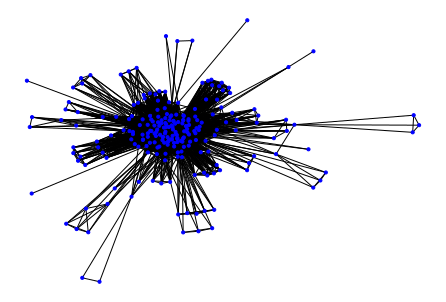

In [110]:
# draw network
import matplotlib.pyplot as plt
np.random.seed(1234)
plt.figure(figsize=(6,4))
graph=nx.draw(DN_all_links, with_labels=False, node_size=10, node_color='b')
#plt.savefig("graph.svg", bbox_inches='tight') 

## Creation of node features

We now build on the preliminary node features dataset we created above and prepare further variables to merge to the dataset.

In [111]:
degree_dict = dict(DN_all_links.degree)
degree_dict

{1: 85,
 60: 122,
 128: 85,
 8: 51,
 63: 103,
 111: 87,
 221: 123,
 110: 117,
 100: 127,
 59: 112,
 116: 112,
 129: 121,
 117: 121,
 55: 39,
 17: 99,
 159: 99,
 53: 116,
 206: 77,
 2: 35,
 148: 60,
 228: 58,
 127: 117,
 130: 75,
 145: 57,
 24: 114,
 163: 114,
 5: 29,
 6: 87,
 14: 69,
 149: 87,
 131: 79,
 42: 63,
 97: 119,
 11: 107,
 112: 123,
 12: 31,
 13: 51,
 19: 112,
 99: 91,
 137: 91,
 58: 118,
 48: 103,
 162: 103,
 123: 113,
 93: 93,
 67: 90,
 161: 90,
 107: 117,
 37: 108,
 57: 107,
 218: 115,
 101: 121,
 43: 97,
 64: 52,
 203: 110,
 214: 120,
 88: 70,
 25: 40,
 211: 117,
 106: 126,
 22: 100,
 23: 40,
 215: 44,
 216: 44,
 26: 82,
 91: 49,
 147: 82,
 28: 68,
 31: 91,
 210: 103,
 32: 104,
 56: 123,
 36: 124,
 133: 69,
 104: 92,
 151: 97,
 200: 100,
 44: 24,
 47: 26,
 51: 80,
 80: 108,
 119: 87,
 84: 109,
 105: 18,
 76: 59,
 92: 100,
 219: 95,
 220: 95,
 98: 85,
 217: 30,
 196: 69,
 122: 99,
 141: 99,
 140: 111,
 113: 72,
 120: 104,
 208: 117,
 152: 104,
 207: 49,
 177: 52,
 143: 78,

In [112]:
degree_centrality_dict = nx.degree_centrality(DN_all_links)
degree_centrality_dict

{1: 0.37280701754385964,
 60: 0.5350877192982456,
 128: 0.37280701754385964,
 8: 0.22368421052631576,
 63: 0.45175438596491224,
 111: 0.381578947368421,
 221: 0.5394736842105263,
 110: 0.513157894736842,
 100: 0.5570175438596491,
 59: 0.49122807017543857,
 116: 0.49122807017543857,
 129: 0.5307017543859649,
 117: 0.5307017543859649,
 55: 0.17105263157894735,
 17: 0.43421052631578944,
 159: 0.43421052631578944,
 53: 0.5087719298245614,
 206: 0.33771929824561403,
 2: 0.15350877192982454,
 148: 0.2631578947368421,
 228: 0.2543859649122807,
 127: 0.513157894736842,
 130: 0.3289473684210526,
 145: 0.25,
 24: 0.5,
 163: 0.5,
 5: 0.12719298245614036,
 6: 0.381578947368421,
 14: 0.3026315789473684,
 149: 0.381578947368421,
 131: 0.3464912280701754,
 42: 0.2763157894736842,
 97: 0.5219298245614035,
 11: 0.46929824561403505,
 112: 0.5394736842105263,
 12: 0.13596491228070173,
 13: 0.22368421052631576,
 19: 0.49122807017543857,
 99: 0.3991228070175438,
 137: 0.3991228070175438,
 58: 0.51754385964

In [113]:
eigenvector_centrality_dict = nx.eigenvector_centrality(DN_all_links)
eigenvector_centrality_dict

{1: 0.08943610847388528,
 60: 0.11677292677937065,
 128: 0.08943610847388528,
 8: 0.05937258769667549,
 63: 0.10301470706045142,
 111: 0.08986608584716257,
 221: 0.11772067709925962,
 110: 0.11356873748604705,
 100: 0.11772149382221153,
 59: 0.10971528262458714,
 116: 0.11210812668531996,
 129: 0.11710909486877491,
 117: 0.11742170457749801,
 55: 0.03919666522530791,
 17: 0.10510980844140981,
 159: 0.10510980844140981,
 53: 0.11416150090110803,
 206: 0.07854746689495336,
 2: 0.04035813079451237,
 148: 0.06205719425213873,
 228: 0.0644007673245762,
 127: 0.11355404459214159,
 130: 0.07868443163301175,
 145: 0.06024422578529536,
 24: 0.11125818348763937,
 163: 0.11125818348763937,
 5: 0.034760200930602975,
 6: 0.09463566755328373,
 14: 0.07019663093283086,
 149: 0.09463566755328373,
 131: 0.08937229369179202,
 42: 0.06750250540733099,
 97: 0.11411855827289483,
 11: 0.10868903792757427,
 112: 0.11566129446552657,
 12: 0.0335751620156906,
 13: 0.058099053953490964,
 19: 0.10903210186307934

In [114]:
closeness_centrality_dict = nx.closeness_centrality(DN_all_links)
closeness_centrality_dict

{1: 0.5861182519280206,
 60: 0.672566371681416,
 128: 0.5861182519280206,
 8: 0.5193621867881549,
 63: 0.6229508196721312,
 111: 0.5861182519280206,
 221: 0.672566371681416,
 110: 0.6627906976744186,
 100: 0.6867469879518072,
 59: 0.6368715083798883,
 116: 0.6532951289398281,
 129: 0.6666666666666666,
 117: 0.6686217008797654,
 55: 0.4851063829787234,
 17: 0.628099173553719,
 159: 0.628099173553719,
 53: 0.6589595375722543,
 206: 0.562962962962963,
 2: 0.5100671140939598,
 148: 0.5454545454545454,
 228: 0.5441527446300716,
 127: 0.6589595375722543,
 130: 0.5671641791044776,
 145: 0.5415676959619953,
 24: 0.6589595375722543,
 163: 0.6589595375722543,
 5: 0.475,
 6: 0.5922077922077922,
 14: 0.5615763546798029,
 149: 0.5922077922077922,
 131: 0.57,
 42: 0.5327102803738317,
 97: 0.6627906976744186,
 11: 0.6404494382022472,
 112: 0.6745562130177515,
 12: 0.48,
 13: 0.5181818181818182,
 19: 0.6570605187319885,
 99: 0.6063829787234043,
 137: 0.6063829787234043,
 58: 0.6608695652173913,
 48: 0

In [115]:
betweenness_centrality_dict = nx.betweenness_centrality(DN_all_links)
betweenness_centrality_dict

{1: 0.0036046896998862916,
 60: 0.009134644642420408,
 128: 0.0036046896998862916,
 8: 0.0006351635853985849,
 63: 0.005766913636516984,
 111: 0.002714589639192213,
 221: 0.008993403997463272,
 110: 0.008142733029233806,
 100: 0.019889100981977718,
 59: 0.005911531180094538,
 116: 0.008616266192788869,
 129: 0.011068282304047996,
 117: 0.0075990454199369424,
 55: 0.0009836998381695767,
 17: 0.0038108590869820095,
 159: 0.0038108590869820095,
 53: 0.008543438022010172,
 206: 0.005096023933135318,
 2: 0.0,
 148: 0.004126888983245226,
 228: 0.0010910012998565182,
 127: 0.017098527340563788,
 130: 0.00261028197579661,
 145: 0.00976432990349402,
 24: 0.018211369708660486,
 163: 0.018211369708660486,
 5: 3.023398744967591e-05,
 6: 0.01050772547103509,
 14: 0.012746608313406904,
 149: 0.01050772547103509,
 131: 0.0022777552463369055,
 42: 0.0031610363429997812,
 97: 0.014040281041827998,
 11: 0.01335495730562413,
 112: 0.01731773047126367,
 12: 0.0011666438153138088,
 13: 0.007271382491152102

In [116]:
# merge degree and centrality measures to node features
node_features['degree'] = node_features['node'].map(degree_dict)
node_features['degree_centrality'] = node_features['node'].map(degree_centrality_dict)
node_features['eigenvector_centrality'] = node_features['node'].map(eigenvector_centrality_dict)
node_features['closeness_centrality'] = node_features['node'].map(closeness_centrality_dict)
node_features['betweenness_centrality'] = node_features['node'].map(betweenness_centrality_dict)

We have finished our node features table in its original format now. We save it as `node_features_unnormalized.pkl`. 

In [117]:
print("saving file corresponding to node_features_unnormalized.pkl")
node_features.to_pickle("./node_features_unnormalized.pkl")
pd.read_pickle("./node_features_unnormalized.pkl")

saving file corresponding to node_features_unnormalized.pkl


,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,patients_taf_mek_combo,sales_kisqali,sales_taf_mek_combo,num_papers,node,degree,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.0,466.0,0.0,0,0,4,0.017544,0.003601,0.406417,0.000000
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.0,7962.0,0.0,13,1,85,0.372807,0.089436,0.586118,0.003605
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.0,23535.0,0.0,1,2,35,0.153509,0.040358,0.510067,0.000000
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,0.0,985.0,0.0,0,3,4,0.017544,0.001211,0.360759,0.000000
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,0.0,1797.0,0.0,5,4,12,0.052632,0.011124,0.455090,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,Melanoma,T2,S3,0012o00002iEaBJ,...,163.0,0.0,12220.0,1,224,19,0.083333,0.011180,0.432638,0.000000
225,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.0,4283.0,0.0,46,225,57,0.250000,0.054953,0.533958,0.006390
226,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,45.0,0.0,2534.0,1,226,6,0.026316,0.001799,0.393782,0.000350
227,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,120.0,0.0,8826.0,1,227,9,0.039474,0.004665,0.410811,0.000000


In order to use the node features dataset for later tasks, we need to convert the node features: Categorical node features need to be dummy coded and metric node features can either be normalized or standardized.

The next plot helps us to decide which transformation to use for the metric node features.

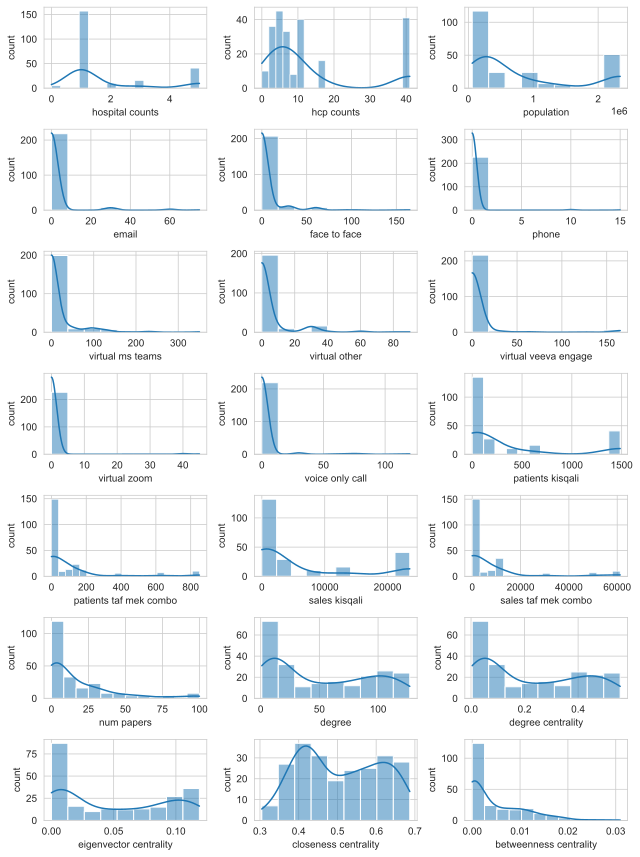

In [118]:
# Plot distribution of metric node features

sns.set_style("whitegrid") 

# define plotting region (2 columns)
fig, axes = plt.subplots(7,3, figsize=(9,12)) 

#create boxplot in each subplot
fig1 = sns.histplot(data=node_features, x="hospital_counts", kde=True, ax=axes[0,0])
fig1.set(xlabel ="hospital counts", ylabel = "count")
fig2 = sns.histplot(data=node_features, x='hcp_counts', kde = True, ax=axes[0,1])
fig2.set(xlabel ="hcp counts", ylabel = "count")
fig3 = sns.histplot(data=node_features, x='population', kde = True, ax=axes[0,2])
fig3.set(xlabel ="population", ylabel = "count")
fig4 = sns.histplot(data=node_features, x='email', kde = True, ax=axes[1,0])
fig4.set(xlabel ="email", ylabel = "count")
fig5 = sns.histplot(data = node_features, x='face_to_face', kde=True, ax=axes[1,1])
fig5.set(xlabel ="face to face", ylabel = "count")
fig6 = sns.histplot(data = node_features, x='phone', kde=True, ax=axes[1,2])
fig6.set(xlabel ="phone", ylabel = "count")
fig7 = sns.histplot(data = node_features, x='virtual_ms_teams', kde=True, ax=axes[2,0])
fig7.set(xlabel ="virtual ms teams", ylabel = "count")
fig8 = sns.histplot(data = node_features, x='virtual_other', kde=True, ax=axes[2,1])
fig8.set(xlabel ="virtual other", ylabel = "count")
fig9 = sns.histplot(data = node_features, x='virtual_veeva_engage', kde=True, ax=axes[2,2])
fig9.set(xlabel ="virtual veeva engage", ylabel = "count")
fig10 = sns.histplot(data = node_features, x='virtual_zoom', kde=True, ax=axes[3,0])
fig10.set(xlabel ="virtual zoom", ylabel = "count")
fig11 = sns.histplot(data = node_features, x='voice_only_call', kde=True, ax=axes[3,1])
fig11.set(xlabel ="voice only call", ylabel = "count")
fig12 = sns.histplot(data = node_features, x='patients_kisqali', kde=True, ax=axes[3,2])
fig12.set(xlabel ="patients kisqali", ylabel = "count")
fig13 = sns.histplot(data = node_features, x='patients_taf_mek_combo', kde=True, ax=axes[4,0])
fig13.set(xlabel ="patients taf mek combo", ylabel = "count")
fig14 = sns.histplot(data = node_features, x='sales_kisqali', kde=True, ax=axes[4,1])
fig14.set(xlabel ="sales kisqali", ylabel = "count")
fig15 = sns.histplot(data = node_features, x='sales_taf_mek_combo', kde=True, ax=axes[4,2])
fig15.set(xlabel ="sales taf mek combo", ylabel = "count")
fig16 = sns.histplot(data = node_features, x='num_papers', kde=True, ax=axes[5,0])
fig16.set(xlabel ="num papers", ylabel = "count")
fig17 = sns.histplot(data = node_features, x='degree', kde=True, ax=axes[5,1])
fig17.set(xlabel ="degree", ylabel = "count")
fig18 = sns.histplot(data = node_features, x='degree_centrality', kde=True, ax=axes[5,2])
fig18.set(xlabel ="degree centrality", ylabel = "count")
fig19 = sns.histplot(data = node_features, x='eigenvector_centrality', kde=True, ax=axes[6,0])
fig19.set(xlabel ="eigenvector centrality", ylabel = "count")
fig20 = sns.histplot(data = node_features, x='closeness_centrality', kde=True, ax=axes[6,1])
fig20.set(xlabel ="closeness centrality", ylabel = "count")
fig21 = sns.histplot(data = node_features, x='betweenness_centrality', kde=True, ax=axes[6,2])
fig21.set(xlabel ="betweenness centrality", ylabel = "count")

plt.tight_layout() 

#plt.savefig("distribution_metric_variables.svg", bbox_inches='tight')

Since none of the metric node features is normally distributed or approximately normally distributed, we choose normalization.

In the next steps, we normalize the metric and node features and dummy code the categorical node features. Before that, we filter the node features.

In [119]:
node_features = node_features.filter(items=['account_type', 'top_account_name', 'indication', 'tier', 'segment', 
                                            'hospital_counts', 'hcp_counts',
                    'population', 'email', 'face_to_face', 'phone', 'virtual_ms_teams', 'virtual_other', 'virtual_veeva_engage',
                    'virtual_zoom', 'voice_only_call', 'patients_kisqali', 'patients_taf_mek_combo', 'sales_kisqali',
                    'sales_taf_mek_combo', 'num_papers', 'degree', 'degree_centrality', 'eigenvector_centrality',
                    'closeness_centrality', 'betweenness_centrality'])

# normalize variables
normalize(node_features, 'hospital_counts')
normalize(node_features, 'hcp_counts')
normalize(node_features, 'population')
normalize(node_features, 'email')
normalize(node_features, 'face_to_face')
normalize(node_features, 'phone')
normalize(node_features, 'virtual_ms_teams')
normalize(node_features, 'virtual_other')
normalize(node_features, 'virtual_veeva_engage')
normalize(node_features, 'virtual_zoom')
normalize(node_features, 'voice_only_call')
normalize(node_features, 'patients_kisqali')
normalize(node_features, 'patients_taf_mek_combo')
normalize(node_features, 'sales_kisqali')
normalize(node_features, 'sales_taf_mek_combo')
normalize(node_features, 'num_papers')
normalize(node_features, 'degree')
normalize(node_features, 'degree_centrality')
normalize(node_features, 'eigenvector_centrality')
normalize(node_features, 'closeness_centrality')
normalize(node_features, 'betweenness_centrality')

# one-hot-encode them
node_features = dummy_encode(node_features, 'account_type')
node_features = dummy_encode(node_features, 'top_account_name')
node_features = dummy_encode(node_features, 'indication')
node_features = dummy_encode(node_features, 'tier')
node_features = dummy_encode(node_features, 'segment')

node_features

,hospital_counts_norm,hcp_counts_norm,population_norm,email_norm,face_to_face_norm,phone_norm,virtual_ms_teams_norm,virtual_other_norm,virtual_veeva_engage_norm,virtual_zoom_norm,...,NT,ST,T1,T2,T3,T4,S1,S2,S3,S4
0,0.2,0.097561,0.070234,0.0,0.000000,0.0,0.000000,0.000000,0.181818,0.0,...,0,0,0,0,1,0,0,0,1,0
1,0.4,0.243902,0.207327,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
2,1.0,1.000000,1.000000,0.0,0.363636,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,1,0,0
3,0.2,0.073171,0.094795,0.0,0.636364,0.0,0.000000,0.444444,0.000000,0.0,...,0,0,0,1,0,0,0,1,0,0
4,0.2,0.024390,0.034352,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0.2,0.243902,0.092450,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0
225,0.2,0.146341,0.061021,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
226,0.2,0.024390,0.061610,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0
227,0.2,0.097561,0.132168,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0


These are the node features that we can leverage for node classification and link prediction. We save them as `node_features.pkl`.

In [ ]:
# Save the final node features

print("saving file corresponding to node_features.pkl")
node_features.to_pickle("./node_features.pkl")
pd.read_pickle("./node_features.pkl")

## 3. Creation of edge features

For each link in our HCP graph, we now create its three edge features, i.e., three variables that indicate if the link is of the type 'paper_link', 'journal_link' and/or 'hospital_link'.

In [120]:
# edge features matrix
edge_features = pd.DataFrame(data = all_links, columns=['node_1', 'node_2'])

# create columns: paper_link, journal_link, hospital_link

for i in range(len(edge_features)):
    # paper_link
    if [edge_features['node_1'][i], edge_features['node_2'][i]] in paper_links:
        edge_features.at[i, 'paper_link'] = 1
    else:
        edge_features.at[i, 'paper_link'] = 0
        
    # journal_link
    if [edge_features['node_1'][i], edge_features['node_2'][i]] in journal_links:
        edge_features.at[i, 'journal_link'] = 1
    else:
        edge_features.at[i, 'journal_link'] = 0
        
    # hospital_link  
    if [edge_features['node_1'][i], edge_features['node_2'][i]] in hospital_links:
        edge_features.at[i, 'hospital_link'] = 1
    else:
        edge_features.at[i, 'hospital_link'] = 0
        
edge_features

,node_1,node_2,paper_link,journal_link,hospital_link
0,1,60,1.0,1.0,0.0
1,128,60,1.0,1.0,0.0
2,1,8,1.0,1.0,0.0
3,128,8,1.0,1.0,0.0
4,1,63,1.0,1.0,0.0
...,...,...,...,...,...
5816,68,174,0.0,0.0,1.0
5817,70,136,0.0,0.0,1.0
5818,81,172,0.0,0.0,1.0
5819,95,167,0.0,0.0,1.0


In [ ]:
# Save the edge features
    
print("saving file corresponding to edge_features.pkl")
edge_features.to_pickle("./edge_features.pkl")
pd.read_pickle("./edge_features.pkl")

Finally, we also save `all_links.txt`. In addition, we create and save a dictionary `variables_dict` that indicates what index of the node features is assigned to which node feature.

In [152]:
with open('all_links.txt', 'w') as f:
    f.write(json.dumps(all_links))

with open('all_links.txt', 'r') as f:
    all_links = json.loads(f.read())

In [121]:
# create variable dict
node_features.columns
variables_dict = dict()
for i, variable_name in enumerate(list(node_features.columns)):
    variables_dict.update({f"{i+1}": variable_name})
variables_dict

{'1': 'hospital_counts_norm',
 '2': 'hcp_counts_norm',
 '3': 'population_norm',
 '4': 'email_norm',
 '5': 'face_to_face_norm',
 '6': 'phone_norm',
 '7': 'virtual_ms_teams_norm',
 '8': 'virtual_other_norm',
 '9': 'virtual_veeva_engage_norm',
 '10': 'virtual_zoom_norm',
 '11': 'voice_only_call_norm',
 '12': 'patients_kisqali_norm',
 '13': 'patients_taf_mek_combo_norm',
 '14': 'sales_kisqali_norm',
 '15': 'sales_taf_mek_combo_norm',
 '16': 'num_papers_norm',
 '17': 'degree_norm',
 '18': 'degree_centrality_norm',
 '19': 'eigenvector_centrality_norm',
 '20': 'closeness_centrality_norm',
 '21': 'betweenness_centrality_norm',
 '22': 'Doctor',
 '23': 'Nurse',
 '24': 'Akademiska sjukhuset',
 '25': 'Blekingesjukhuset i Karlskrona',
 '26': 'Capio S:t Görans Sjukhus AB',
 '27': 'Centrallasarettet Växjö',
 '28': 'Centralsjukhuset i Karlstad',
 '29': 'Drottningmottagningen',
 '30': 'Falu Lasarett',
 '31': 'Gävle Sjukhus',
 '32': 'Hallands sjukhus Halmstad',
 '33': 'Hallands sjukhus Varberg',
 '34': 

In [155]:
with open('./variables_dict.pkl', 'wb') as f:
    pickle.dump(variables_dict, f)
        
with open('./variables_dict.pkl', 'rb') as f:
    variables_dict = pickle.load(f)